In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from pathlib import Path
from scipy import stats as scipy_stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.model_selection import GridSearchCV
from pathlib import Path
from typing import Dict, Any, List, Optional
warnings.filterwarnings('ignore')

# Load datasets
df_baseline_block_latency = pd.read_csv("baseline/block_count_latency_device.csv")
df_baseline_read_bytes = pd.read_csv("baseline/read_bytes.csv")
df_baseline_write_bytes = pd.read_csv("baseline/write_bytes.csv")

df_cpustress_block_latency = pd.read_csv("cpu stress/block_count_latency_device.csv")
df_cpustress_read_bytes = pd.read_csv("cpu stress/read_bytes.csv")
df_cpustress_write_bytes = pd.read_csv("cpu stress/write_bytes.csv")

df_delay_block_latency = pd.read_csv("delay/block_count_latency_device.csv")
df_delay_read_bytes = pd.read_csv("delay/read_bytes.csv")
df_delay_write_bytes = pd.read_csv("delay/write_bytes.csv")

df_memstress_block_latency = pd.read_csv("mem stress/block_count_latency_device.csv")
df_memstress_read_bytes = pd.read_csv("mem stress/read_bytes.csv")
df_memstress_write_bytes = pd.read_csv("mem stress/write_bytes.csv")

df_netloss_block_latency = pd.read_csv("netloss/block_count_latency_device.csv")
df_netloss_read_bytes = pd.read_csv("netloss/read_bytes.csv")
df_netloss_write_bytes = pd.read_csv("netloss/write_bytes.csv")

# Add source labels
for df, source in [(df_baseline_block_latency, "BASELINE"), (df_baseline_read_bytes, "BASELINE"), (df_baseline_write_bytes, "BASELINE"),
                   (df_cpustress_block_latency, "CPU_STRESS"), (df_cpustress_read_bytes, "CPU_STRESS"), (df_cpustress_write_bytes, "CPU_STRESS"),
                   (df_delay_block_latency, "DELAY"), (df_delay_read_bytes, "DELAY"), (df_delay_write_bytes, "DELAY"),
                   (df_memstress_block_latency, "MEM_STRESS"), (df_memstress_read_bytes, "MEM_STRESS"), (df_memstress_write_bytes, "MEM_STRESS"),
                   (df_netloss_block_latency, "NET_LOSS"), (df_netloss_read_bytes, "NET_LOSS"), (df_netloss_write_bytes, "NET_LOSS")]:
    df["source"] = source

# Convert to datetime
all_dfs = [df_baseline_block_latency, df_baseline_read_bytes, df_baseline_write_bytes,
           df_cpustress_block_latency, df_cpustress_read_bytes, df_cpustress_write_bytes,
           df_delay_block_latency, df_delay_read_bytes, df_delay_write_bytes,
           df_memstress_block_latency, df_memstress_read_bytes, df_memstress_write_bytes,
           df_netloss_block_latency, df_netloss_read_bytes, df_netloss_write_bytes]

for df in all_dfs:
    df["Time"] = pd.to_datetime(df["Time"])

# Synchronize timelines
time_offset = df_baseline_block_latency["Time"].min()

for df_group in [(df_cpustress_block_latency, df_cpustress_read_bytes, df_cpustress_write_bytes),
                 (df_delay_block_latency, df_delay_read_bytes, df_delay_write_bytes),
                 (df_memstress_block_latency, df_memstress_read_bytes, df_memstress_write_bytes),
                 (df_netloss_block_latency, df_netloss_read_bytes, df_netloss_write_bytes)]:
    offset = time_offset - df_group[0]["Time"].min()
    for df in df_group:
        df["Time"] += offset

# Convert to minutes
for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# Dataset structure
all_datasets = {
    'BlockLatency': {
        'baseline': df_baseline_block_latency,
        'cpu_stress': df_cpustress_block_latency,
        'delay': df_delay_block_latency,
        'mem_stress': df_memstress_block_latency,
        'net_loss': df_netloss_block_latency,
    },
    'ReadBytes': {
        'baseline': df_baseline_read_bytes,
        'cpu_stress': df_cpustress_read_bytes,
        'delay': df_delay_read_bytes,
        'mem_stress': df_memstress_read_bytes,
        'net_loss': df_netloss_read_bytes,
    },
    'WriteBytes': {
        'baseline': df_baseline_write_bytes,
        'cpu_stress': df_cpustress_write_bytes,
        'delay': df_delay_write_bytes,
        'mem_stress': df_memstress_write_bytes,
        'net_loss': df_netloss_write_bytes,
    }
}

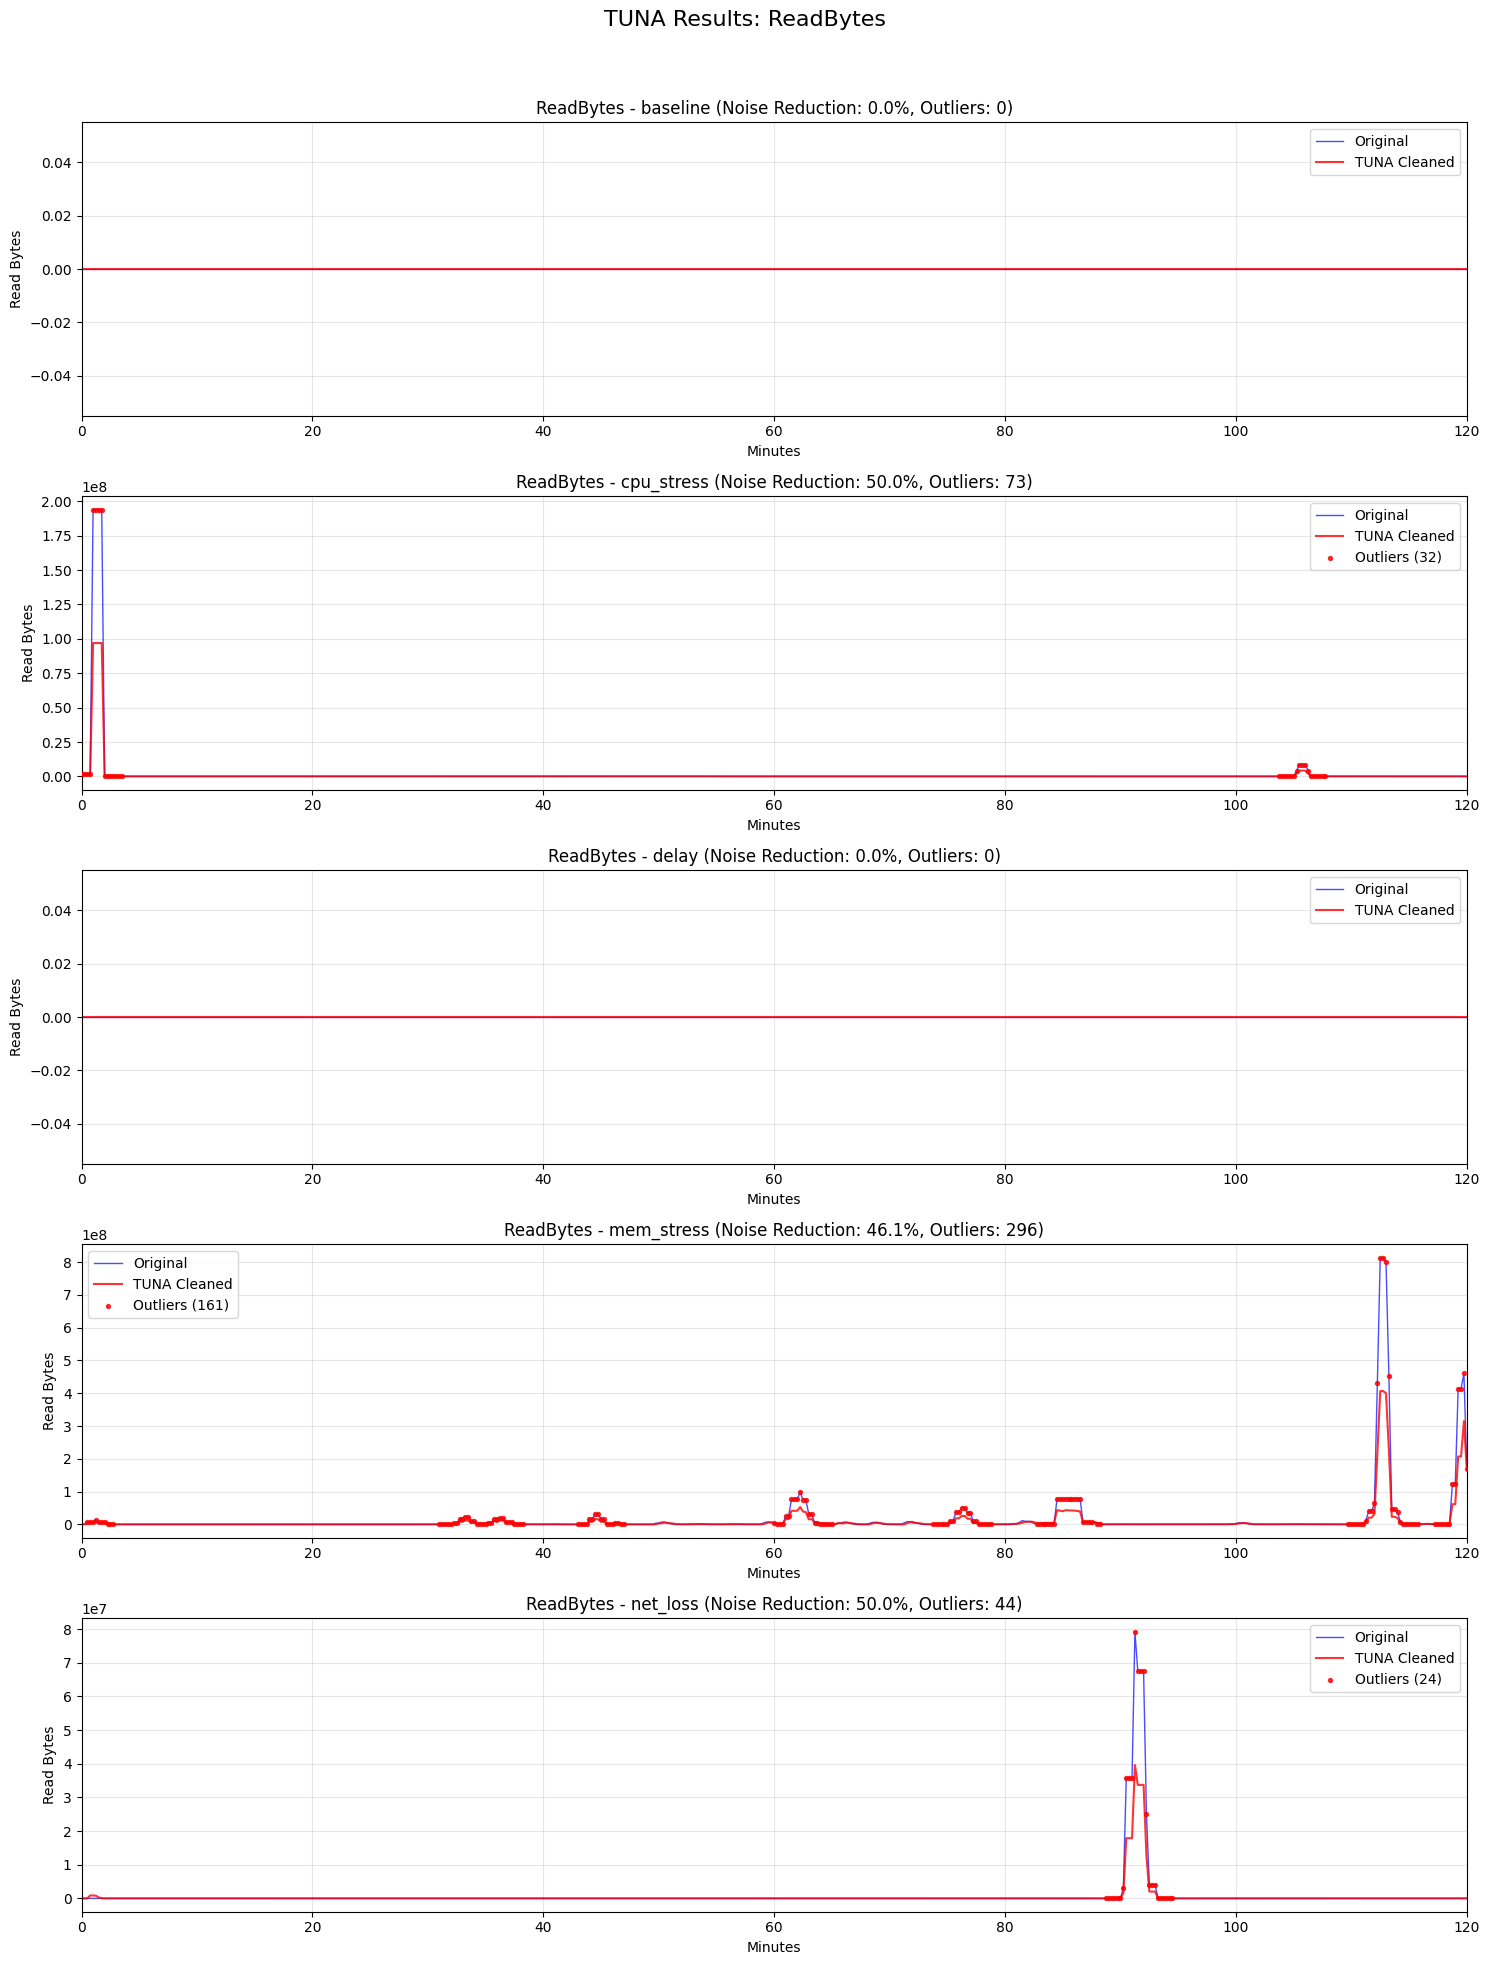

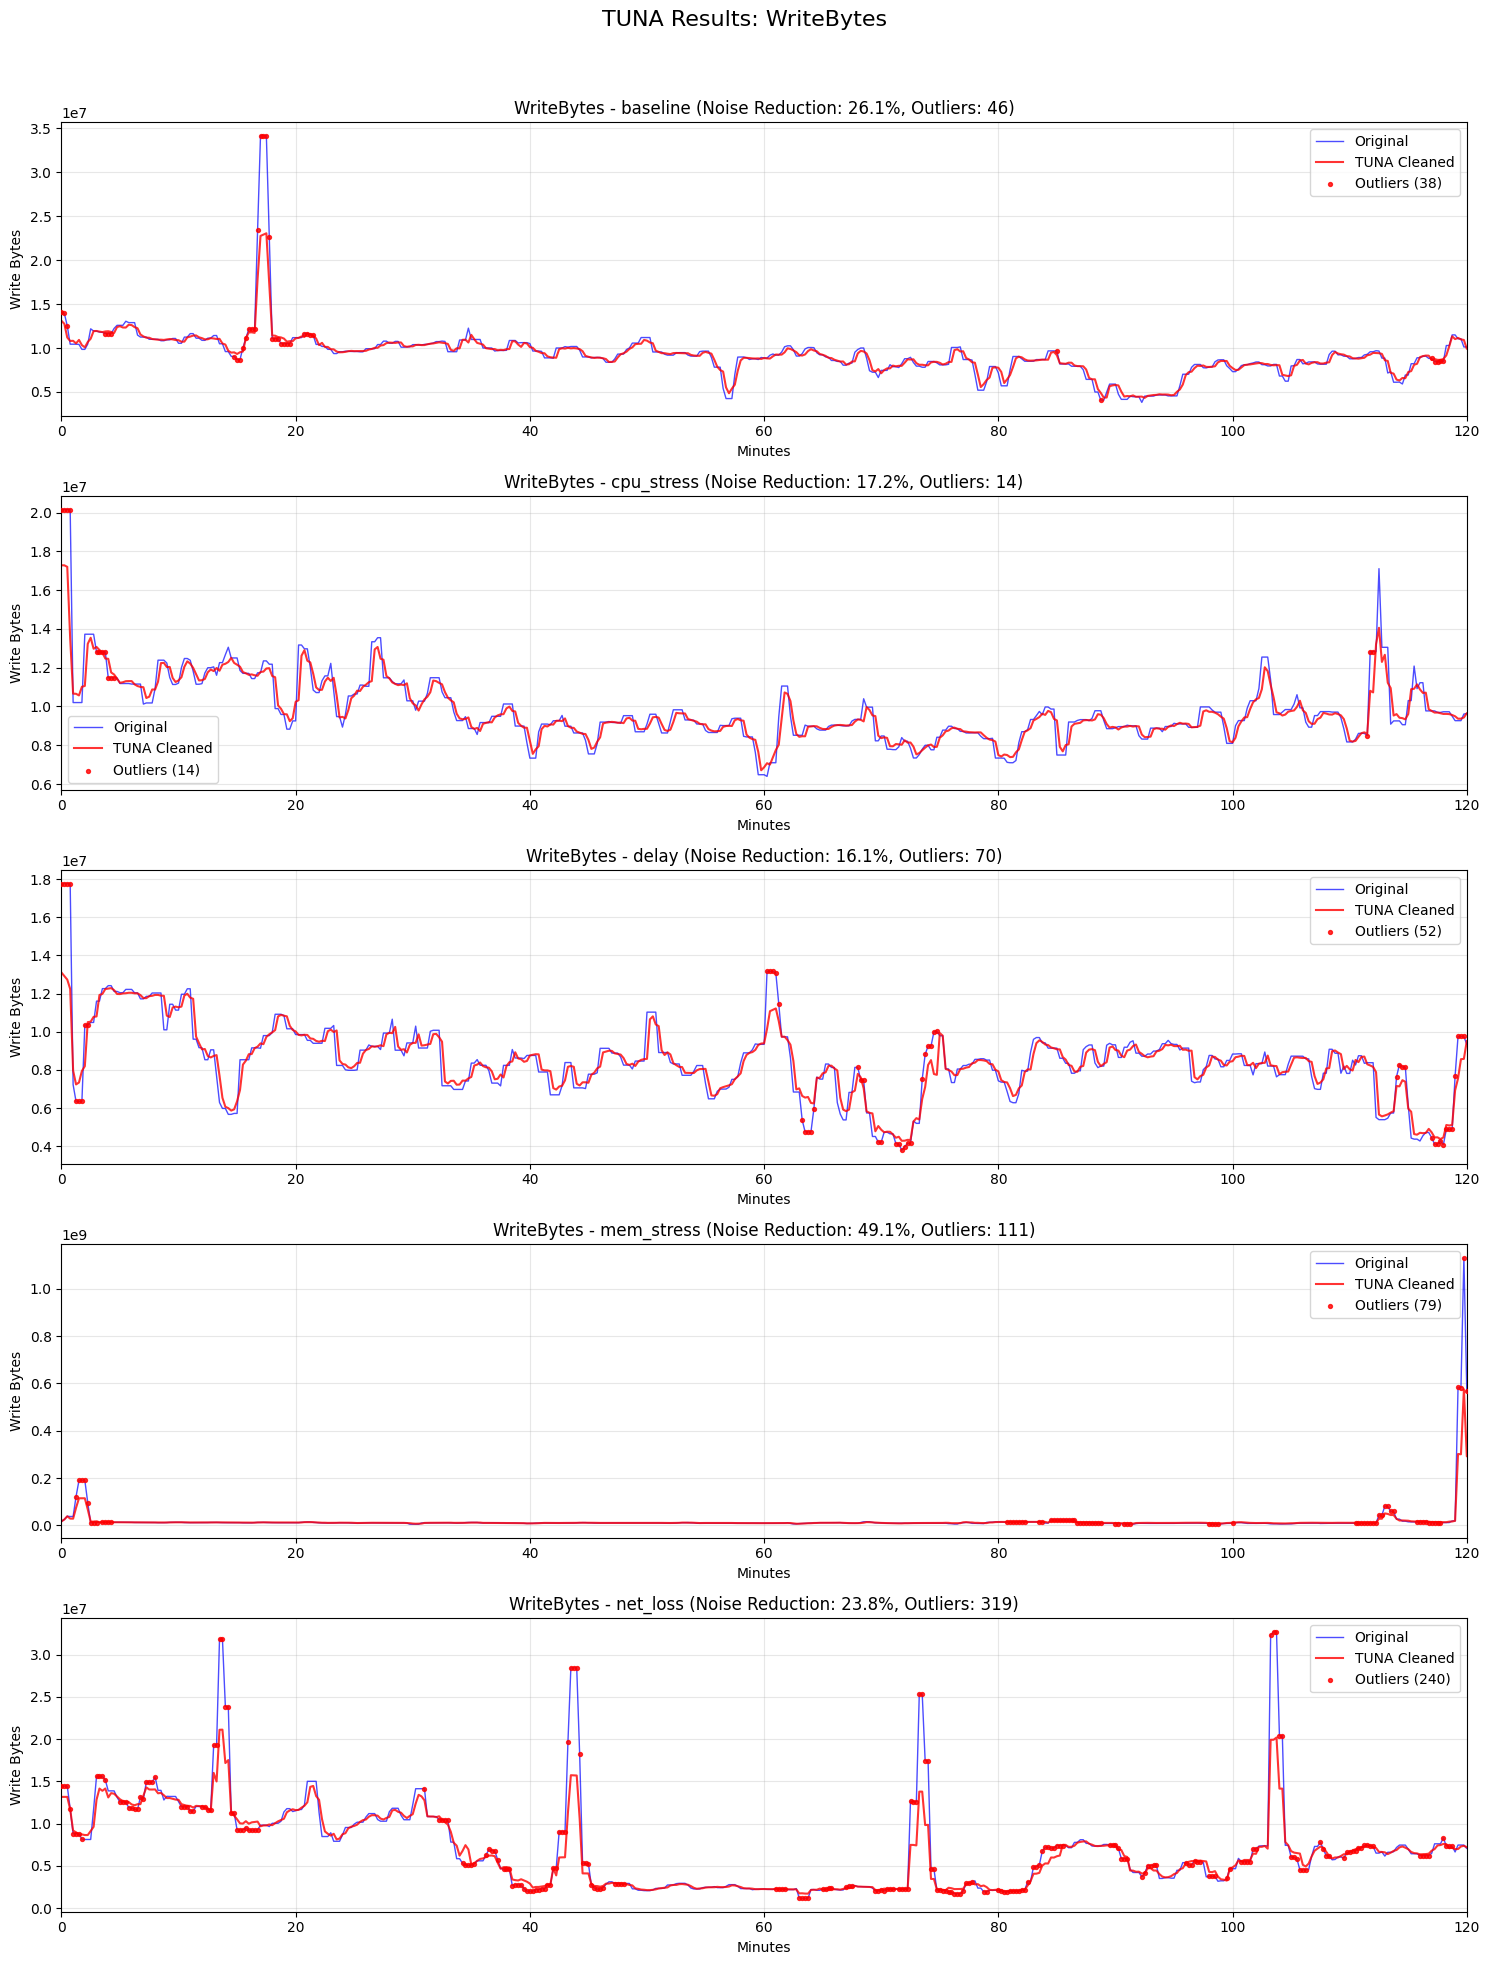


TUNA IO Results Summary:
Metric          Experiment      Outliers   Noise Red%   Correlation 
----------------------------------------------------------------------
ReadBytes       baseline        0                 0.0%       1.000
ReadBytes       cpu_stress      73               50.0%       1.000
ReadBytes       delay           0                 0.0%       1.000
ReadBytes       mem_stress      296              46.1%       0.981
ReadBytes       net_loss        44               50.0%       1.000
WriteBytes      baseline        46               26.1%       0.954
WriteBytes      cpu_stress      14               17.2%       0.944
WriteBytes      delay           70               16.1%       0.933
WriteBytes      mem_stress      111              49.1%       0.999
WriteBytes      net_loss        319              23.8%       0.941


In [ ]:
def get_tuna_parameters_io(metric_name, experiment_type):
    """Get consistent TUNA parameters for IO metrics"""
    
    # Adaptive parameters based on metric type
    if "blockcount" in metric_name.lower():
        window_size = 20
        threshold = 1.5
    elif "readbytes" in metric_name.lower():
        window_size = 8
        threshold = 0.6
    elif "writebytes" in metric_name.lower():
        window_size = 16
        threshold = 1.0
    
    min_absolute_range_factor = 0.2
    penalty_factor = 0.5
    lookback_window = 10
    
    return {
        'window_size': window_size,
        'threshold': threshold,
        'min_absolute_range_factor': min_absolute_range_factor,
        'penalty_factor': penalty_factor,
        'lookback_window': min(lookback_window, 15)
    }

def detect_outliers_tuna_io(timeseries, metric_name="", experiment_type=""):
    """TUNA's relative range outlier detection for IO metrics"""
    
    outlier_mask = np.zeros(len(timeseries), dtype=bool)
    params = get_tuna_parameters_io(metric_name, experiment_type)
    
    window_size = params['window_size']
    threshold = params['threshold']
    min_absolute_range = params['min_absolute_range_factor'] * np.std(timeseries)
    
    for i in range(len(timeseries) - window_size + 1):
        window = timeseries[i:i + window_size]
        window_mean = np.mean(window)
        window_range = np.max(window) - np.min(window)
        
        zero_ratio = np.sum(window == 0) / len(window)
        if zero_ratio > 0.8:  
            continue
        
        if window_mean < 100:  
            continue
            
        if window_mean > 0:
            relative_range = window_range / window_mean
            
            if relative_range > threshold and window_range > min_absolute_range:
                window_max = np.max(window)
                window_min = np.min(window)
                
                for j in range(window_size):
                    actual_idx = i + j
                    if (timeseries[actual_idx] == window_max or 
                        timeseries[actual_idx] == window_min):
                        outlier_mask[actual_idx] = True
    
    return outlier_mask

def get_local_stable_baseline_io(timeseries, stable_mask, current_idx, lookback_window):
    """Get local baseline from recent stable points for IO"""
    
    # Look backwards for recent stable points
    start_idx = max(0, current_idx - lookback_window)
    local_window = timeseries[start_idx:current_idx]
    local_stable_mask = stable_mask[start_idx:current_idx]
    
    recent_stable = local_window[local_stable_mask]
    
    if len(recent_stable) >= 3:
        return np.median(recent_stable)
    elif len(recent_stable) >= 1:
        return np.mean(recent_stable)
    
    # If no recent stable points, look forward
    end_idx = min(len(timeseries), current_idx + lookback_window)
    forward_window = timeseries[current_idx+1:end_idx]
    forward_stable_mask = stable_mask[current_idx+1:end_idx]
    
    forward_stable = forward_window[forward_stable_mask]
    
    if len(forward_stable) >= 1:
        return np.median(forward_stable) if len(forward_stable) >= 3 else np.mean(forward_stable)
    
    # Fallback to global median of stable values
    stable_values = timeseries[stable_mask]
    return np.median(stable_values) if len(stable_values) > 0 else np.median(timeseries)

def apply_penalty_io(timeseries, outlier_mask, metric_name="", experiment_type=""):
    """Apply penalty based on local stable trend for IO"""
    
    cleaned_series = timeseries.copy()
    stable_mask = ~outlier_mask
    params = get_tuna_parameters_io(metric_name, experiment_type)
    
    effective_penalty = params['penalty_factor']
    lookback_window = params['lookback_window']
    
    for i in range(len(timeseries)):
        if outlier_mask[i]:
            local_baseline = get_local_stable_baseline_io(timeseries, stable_mask, i, lookback_window)
            original_value = timeseries[i]
            deviation = original_value - local_baseline
            cleaned_series[i] = local_baseline + deviation * effective_penalty
    
    return cleaned_series

def create_features_for_ml_io(timeseries, stable_mask, experiment_type):
    """Create features ONLY from stable regions for IO"""
    
    features = []
    feature_indices = []
    window_size = 3  # Fixed feature window size
    
    for i in range(window_size, len(timeseries)):
        if stable_mask[i]:
            window = timeseries[i-window_size:i]
            window_stable_mask = stable_mask[i-window_size:i]
            
            # Only create features if at least 80% of the window is stable
            stable_ratio = np.sum(window_stable_mask) / len(window_stable_mask)
            if stable_ratio >= 0.8:
                stable_window = window[window_stable_mask]
                
                if len(stable_window) > 0:
                    feature_vector = [
                        np.mean(stable_window),
                        np.std(stable_window),
                        np.median(stable_window),
                        np.max(stable_window) - np.min(stable_window),
                        timeseries[i-1] if stable_mask[i-1] else np.mean(stable_window),
                        i / len(timeseries),
                    ]
                    
                    # Clean any NaN/inf values
                    feature_vector = [0.0 if np.isnan(val) or np.isinf(val) else float(val) for val in feature_vector]
                    
                    # Experiment type encoding - 5 types for IO
                    exp_features = [0, 0, 0, 0, 0]
                    if experiment_type == "baseline":
                        exp_features[0] = 1
                    elif experiment_type == "cpu_stress":
                        exp_features[1] = 1
                    elif experiment_type == "IO pressure":
                        exp_features[2] = 1
                    elif experiment_type == "mem_stress":
                        exp_features[3] = 1
                    elif experiment_type == "net_loss":
                        exp_features[4] = 1
                    
                    feature_vector.extend(exp_features)
                    features.append(feature_vector)
                    feature_indices.append(i)
    
    return np.array(features), np.array(feature_indices)

def apply_tuna_to_single_series_io(cumulative, exp_name, model, scaler, metric_name=""):
    """Apply TUNA cleaning to a single IO series"""
    
    # Phase 1: Identify outliers
    outlier_mask = detect_outliers_tuna_io(cumulative, metric_name=metric_name, experiment_type=exp_name)
    stable_mask = ~outlier_mask
    outliers_count = np.sum(outlier_mask)
    
    # Phase 2: Apply penalty
    cleaned_series = cumulative.copy()
    if outliers_count > 0:
        cleaned_series = apply_penalty_io(cumulative, outlier_mask, metric_name, exp_name)
    
    # Phase 3: ML enhancement
    if model is not None and scaler is not None:
        features, feature_indices = create_features_for_ml_io(cumulative, stable_mask, exp_name)
        
        if len(features) > 0:
            features_scaled = scaler.transform(features)
            ml_predictions = model.predict(features_scaled)
            
            for i, prediction in enumerate(ml_predictions):
                actual_idx = feature_indices[i]
                if actual_idx < len(cleaned_series) and stable_mask[actual_idx]:
                    if not np.isnan(prediction) and not np.isinf(prediction):
                        # Apply ML prediction to stable points
                        cleaned_series[actual_idx] = prediction
    
    # Calculate statistics
    original_std = np.std(cumulative)
    cleaned_std = np.std(cleaned_series)
    noise_reduction = (original_std - cleaned_std) / original_std * 100
    correlation = np.corrcoef(cumulative, cleaned_series)[0, 1]
    
    return cleaned_series, outlier_mask, {
        'outliers': outliers_count,
        'noise_reduction': noise_reduction,
        'correlation': correlation
    }

def apply_tuna_to_dataframe_io(df, exp_name, models, scalers, metric_name=""):
    """Apply TUNA cleaning to each column in DataFrame for IO"""
    
    exclude_cols = ['Time', 'Minutes', 'source']
    value_cols = [col for col in df.columns if col not in exclude_cols]
    
    column_results = {}
    cleaned_df = df.copy()
    
    for col in value_cols:
        col_values = df[col].values
        model = models.get(col)
        scaler = scalers.get(col)
        
        cleaned_values, outlier_mask, stats = apply_tuna_to_single_series_io(
            col_values, exp_name, model, scaler, metric_name
        )
        
        column_results[col] = {
            'original': col_values,
            'cleaned': cleaned_values,
            'outliers': outlier_mask,
            'stats': stats
        }
        
        cleaned_df[col] = cleaned_values
    
    return cleaned_df, column_results

def train_models_for_all_columns_io(metric_name, all_experiments):
    """Train RandomForest models for each column using stable periods for IO"""
    
    exclude_cols = ['Time', 'Minutes', 'source']
    first_df = list(all_experiments.values())[0]
    value_cols = [col for col in first_df.columns if col not in exclude_cols]
    
    models = {}
    scalers = {}
    
    for col in value_cols:
        X_stable_all = []
        y_stable_all = []
        
        for exp_name, df in all_experiments.items():
            col_values = df[col].values
            outlier_mask = detect_outliers_tuna_io(col_values, metric_name=metric_name, experiment_type=exp_name)
            stable_mask = ~outlier_mask
            
            features, feature_indices = create_features_for_ml_io(col_values, stable_mask, exp_name)
            
            if len(features) > 0:
                stable_targets = col_values[feature_indices]
                
                valid_mask = ~(np.isnan(stable_targets) | np.isinf(stable_targets))
                stable_features = features[valid_mask]
                stable_targets = stable_targets[valid_mask]
                
                if len(stable_features) > 0:
                    # Smooth targets with local median
                    smoothed_targets = []
                    for j, target in enumerate(stable_targets):
                        start_idx = max(0, j-2)
                        end_idx = min(len(stable_targets), j+3)
                        local_values = stable_targets[start_idx:end_idx]
                        smoothed_targets.append(np.median(local_values))
                    
                    X_stable_all.extend(stable_features)
                    y_stable_all.extend(smoothed_targets)
        
        if len(X_stable_all) >= 10:
            X_stable_all = np.array(X_stable_all)
            y_stable_all = np.array(y_stable_all)
            
            # Clean data
            nan_mask = np.isnan(y_stable_all) | np.isinf(y_stable_all)
            if np.any(nan_mask):
                X_stable_all = X_stable_all[~nan_mask]
                y_stable_all = y_stable_all[~nan_mask]
            
            feature_nan_mask = np.isnan(X_stable_all).any(axis=1) | np.isinf(X_stable_all).any(axis=1)
            if np.any(feature_nan_mask):
                X_stable_all = X_stable_all[~feature_nan_mask]
                y_stable_all = y_stable_all[~feature_nan_mask]
            
            if len(X_stable_all) >= 10:
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X_stable_all)
                
                param_grid = {
                    'n_estimators': [100],
                    'max_depth': [5, 10, 15],
                    'min_samples_split': [2, 5],
                    'min_samples_leaf': [1, 2, 4],
                    'max_features': ['sqrt', 'log2']
                }
                
                model = RandomForestRegressor(
                    criterion='squared_error',
                    bootstrap=True,
                    n_jobs=-1,
                    random_state=42
                )
                
                grid_search = GridSearchCV(
                    estimator=model,
                    param_grid=param_grid,
                    scoring='neg_mean_squared_error',
                    cv=3,
                    n_jobs=-1,
                    verbose=0
                )
                
                grid_search.fit(X_scaled, y_stable_all)
                models[col] = grid_search.best_estimator_
                scalers[col] = scaler
            else:
                models[col] = None
                scalers[col] = None
        else:
            models[col] = None
            scalers[col] = None
    
    return models, scalers

def run_tuna_analysis_io(all_datasets):
    """Run TUNA analysis on all IO datasets"""
    
    tuna_results = {}
    
    for metric_name, experiments in all_datasets.items():
        
        # Skip BlockCount metric entirely
        if "blockcount" in metric_name.lower():
            continue
        
        # Check experiments for variance
        valid_experiments = {}
        for exp_name, df in experiments.items():
            exclude_cols = ['Time', 'Minutes', 'source']
            value_cols = [col for col in df.columns if col not in exclude_cols]
            cumulative_values = df[value_cols].sum(axis=1).values
            
            # Check for variance
            has_variance = (np.std(cumulative_values) > 0 and 
                          len(np.unique(cumulative_values)) > 1 and
                          np.max(cumulative_values) > 1000)
            
            if has_variance:
                valid_experiments[exp_name] = df
        
        if not valid_experiments:
            continue
        
        # Train models
        models, scalers = train_models_for_all_columns_io(metric_name, valid_experiments)
        
        metric_results = {}
        for exp_name, df in experiments.items():
            if exp_name in valid_experiments:
                # Apply TUNA cleaning
                cleaned_df, column_results = apply_tuna_to_dataframe_io(
                    df, exp_name, models, scalers, metric_name=metric_name
                )
                
                total_outliers = sum(result['stats']['outliers'] for result in column_results.values())
                
                exclude_cols = ['Time', 'Minutes', 'source']
                value_cols = [col for col in df.columns if col not in exclude_cols]
                
                original_cumulative = df[value_cols].sum(axis=1).values
                cleaned_cumulative = cleaned_df[value_cols].sum(axis=1).values
                
                original_std = np.std(original_cumulative)
                cleaned_std = np.std(cleaned_cumulative)
                noise_reduction = (original_std - cleaned_std) / original_std * 100 if original_std > 0 else 0
                correlation = np.corrcoef(original_cumulative, cleaned_cumulative)[0, 1]
                
                overall_outlier_mask = np.zeros(len(df), dtype=bool)
                for col_result in column_results.values():
                    overall_outlier_mask |= col_result['outliers']
                
                metric_results[exp_name] = {
                    'original': original_cumulative,
                    'cleaned': cleaned_cumulative,
                    'outliers': overall_outlier_mask,
                    'stats': {
                        'outliers': total_outliers,
                        'noise_reduction': noise_reduction,
                        'correlation': correlation
                    },
                    'column_results': column_results,
                    'cleaned_df': cleaned_df
                }
            else:
                # No cleaning for invalid experiments
                exclude_cols = ['Time', 'Minutes', 'source']
                value_cols = [col for col in df.columns if col not in exclude_cols]
                cumulative_values = df[value_cols].sum(axis=1).values
                
                metric_results[exp_name] = {
                    'original': cumulative_values,
                    'cleaned': cumulative_values,
                    'outliers': np.zeros(len(df), dtype=bool),
                    'stats': {
                        'outliers': 0,
                        'noise_reduction': 0.0,
                        'correlation': 1.0
                    },
                    'column_results': {},
                    'cleaned_df': df.copy()
                }
        
        if metric_results:
            tuna_results[metric_name] = metric_results
    
    return tuna_results

def plot_tuna_results_io(tuna_results, all_datasets):
    """Plot TUNA results for IO metrics"""
    
    for metric_name, metric_results in tuna_results.items():
        n_experiments = len(metric_results)
        fig, axes = plt.subplots(n_experiments, 1, figsize=(15, 4*n_experiments))
        
        if n_experiments == 1:
            axes = [axes]
        
        for i, (exp_name, results) in enumerate(metric_results.items()):
            original = results['original']
            cleaned = results['cleaned']
            outliers = results['outliers']
            stats = results['stats']
            
            df = all_datasets[metric_name][exp_name]
            minutes = df['Minutes'].values
            
            # Plot data
            axes[i].plot(minutes, original, 'b-', alpha=0.7, label='Original', linewidth=1)
            axes[i].plot(minutes, cleaned, 'r-', alpha=0.8, label='TUNA Cleaned', linewidth=1.5)
            
            # Mark outliers
            if np.any(outliers):
                outlier_minutes = minutes[outliers]
                outlier_original_values = original[outliers]
                axes[i].scatter(outlier_minutes, outlier_original_values, 
                              color='red', s=8, alpha=0.8, marker='o', 
                              label=f'Outliers ({np.sum(outliers)})', zorder=5)
            
            # Labels
            if 'blockcount' in metric_name.lower():
                y_label = 'Block Count Latency'
            elif 'readbytes' in metric_name.lower():
                y_label = 'Read Bytes'
            elif 'writebytes' in metric_name.lower():
                y_label = 'Write Bytes'
            else:
                y_label = 'IO Values'
            
            axes[i].set_title(f'{metric_name} - {exp_name} (Noise Reduction: {stats["noise_reduction"]:.1f}%, Outliers: {stats["outliers"]})')
            axes[i].set_xlabel('Minutes')
            axes[i].set_ylabel(y_label)
            axes[i].set_xlim(0, 120)
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        
        plt.suptitle(f'TUNA Results: {metric_name}', fontsize=16, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

def print_tuna_summary_io(tuna_results):
    """Print TUNA summary for IO"""
    
    print(f"\nTUNA IO Results Summary:")
    print("="*70)
    print(f"{'Metric':<15} {'Experiment':<15} {'Outliers':<10} {'Noise Red%':<12} {'Correlation':<12}")
    print("-"*70)
    
    for metric_name, metric_results in tuna_results.items():
        for exp_name, results in metric_results.items():
            stats = results['stats']
            print(f"{metric_name:<15} {exp_name:<15} {stats['outliers']:<10} "
                  f"{stats['noise_reduction']:>10.1f}% {stats['correlation']:>11.3f}")

def export_tuna_data_to_csv_io(tuna_results, export_dir="../../noise_reduction_data"):
    """Export TUNA IO results to CSV"""
    
    os.makedirs(export_dir, exist_ok=True)
    export_data = []
    
    for metric_name, metric_data in tuna_results.items():
        for experiment_name, experiment_data in metric_data.items():
            if 'stats' in experiment_data:
                stats = experiment_data['stats']
                export_data.append({
                    'experiment_name': experiment_name,
                    'metric': metric_name,
                    'noise_reduction_pct': stats.get('noise_reduction', 0.0),
                    'correlation': stats.get('correlation', 1.0),
                    'outliers_removed': stats.get('outliers', 0),
                })
    
    csv_filename = "gateway_tuna_io.csv"
    csv_path = os.path.join(export_dir, csv_filename)
    
    df_simple = pd.DataFrame(export_data)
    df_simple.to_csv(csv_path, index=False)
    return csv_path

def create_cleaned_csv_from_tuna_columns(original_df, column_results, metric_name, experiment_name, include_metadata=False):
    """Create a new DataFrame with TUNA-cleaned values"""
    
    cleaned_df = original_df.copy()
    
    exclude_cols = ['Time', 'Minutes', 'source']
    value_cols = [col for col in cleaned_df.columns if col not in exclude_cols]
    
    total_outliers = 0
    
    for col in value_cols:
        if col in column_results:
            cleaned_values = column_results[col]['cleaned']
            cleaned_df[col] = cleaned_values[:len(cleaned_df)]
            total_outliers += column_results[col]['stats']['outliers']
    
    if include_metadata:
        cleaned_df['tuna_processed'] = True
        cleaned_df['tuna_total_outliers'] = total_outliers
        cleaned_df['tuna_metric_name'] = metric_name
        cleaned_df['tuna_experiment'] = experiment_name
        
        for col in value_cols:
            if col in column_results:
                outlier_mask = column_results[col]['outliers']
                cleaned_df[f'tuna_outlier_{col}'] = outlier_mask[:len(cleaned_df)]
                cleaned_df[f'tuna_noise_reduction_{col}'] = column_results[col]['stats']['noise_reduction']
                cleaned_df[f'tuna_correlation_{col}'] = column_results[col]['stats']['correlation']
    
    return cleaned_df

def export_all_cleaned_csvs_io(tuna_results, all_datasets, output_base_path="cleaned_data", include_metadata=False):
    """Export all TUNA-cleaned datasets organized by experiment type"""
    
    output_base = Path(output_base_path)
    output_base.mkdir(parents=True, exist_ok=True)
    
    created_files = {}
    total_files = 0
    
    experiment_types = set()
    for metric_results in tuna_results.values():
        experiment_types.update(metric_results.keys())
    
    for exp_name in experiment_types:
        exp_dir = output_base / exp_name
        exp_dir.mkdir(exist_ok=True)
        created_files[exp_name] = []
    
    for metric_name, metric_results in tuna_results.items():
        for exp_name, results in metric_results.items():
            original_df = all_datasets[metric_name][exp_name]
            
            if 'column_results' in results:
                column_results = results['column_results']
            else:
                column_results = {}
            
            cleaned_df = create_cleaned_csv_from_tuna_columns(
                original_df=original_df,
                column_results=column_results,
                metric_name=metric_name,
                experiment_name=exp_name,
                include_metadata=include_metadata
            )
            
            csv_filename = f"io_{metric_name.lower()}.csv"
            csv_path = output_base / exp_name / csv_filename
            
            cleaned_df.to_csv(csv_path, index=False)
            created_files[exp_name].append(str(csv_path))
            total_files += 1
    
    return created_files

tuna_results = run_tuna_analysis_io(all_datasets)
plot_tuna_results_io(tuna_results, all_datasets)
print_tuna_summary_io(tuna_results)
csv_path = export_tuna_data_to_csv_io(tuna_results)
cleaned_files = export_all_cleaned_csvs_io(tuna_results, all_datasets)


🔍 Analyzing BlockLatency...

📊 Comparing BlockLatency: cpu_stress stress vs baseline


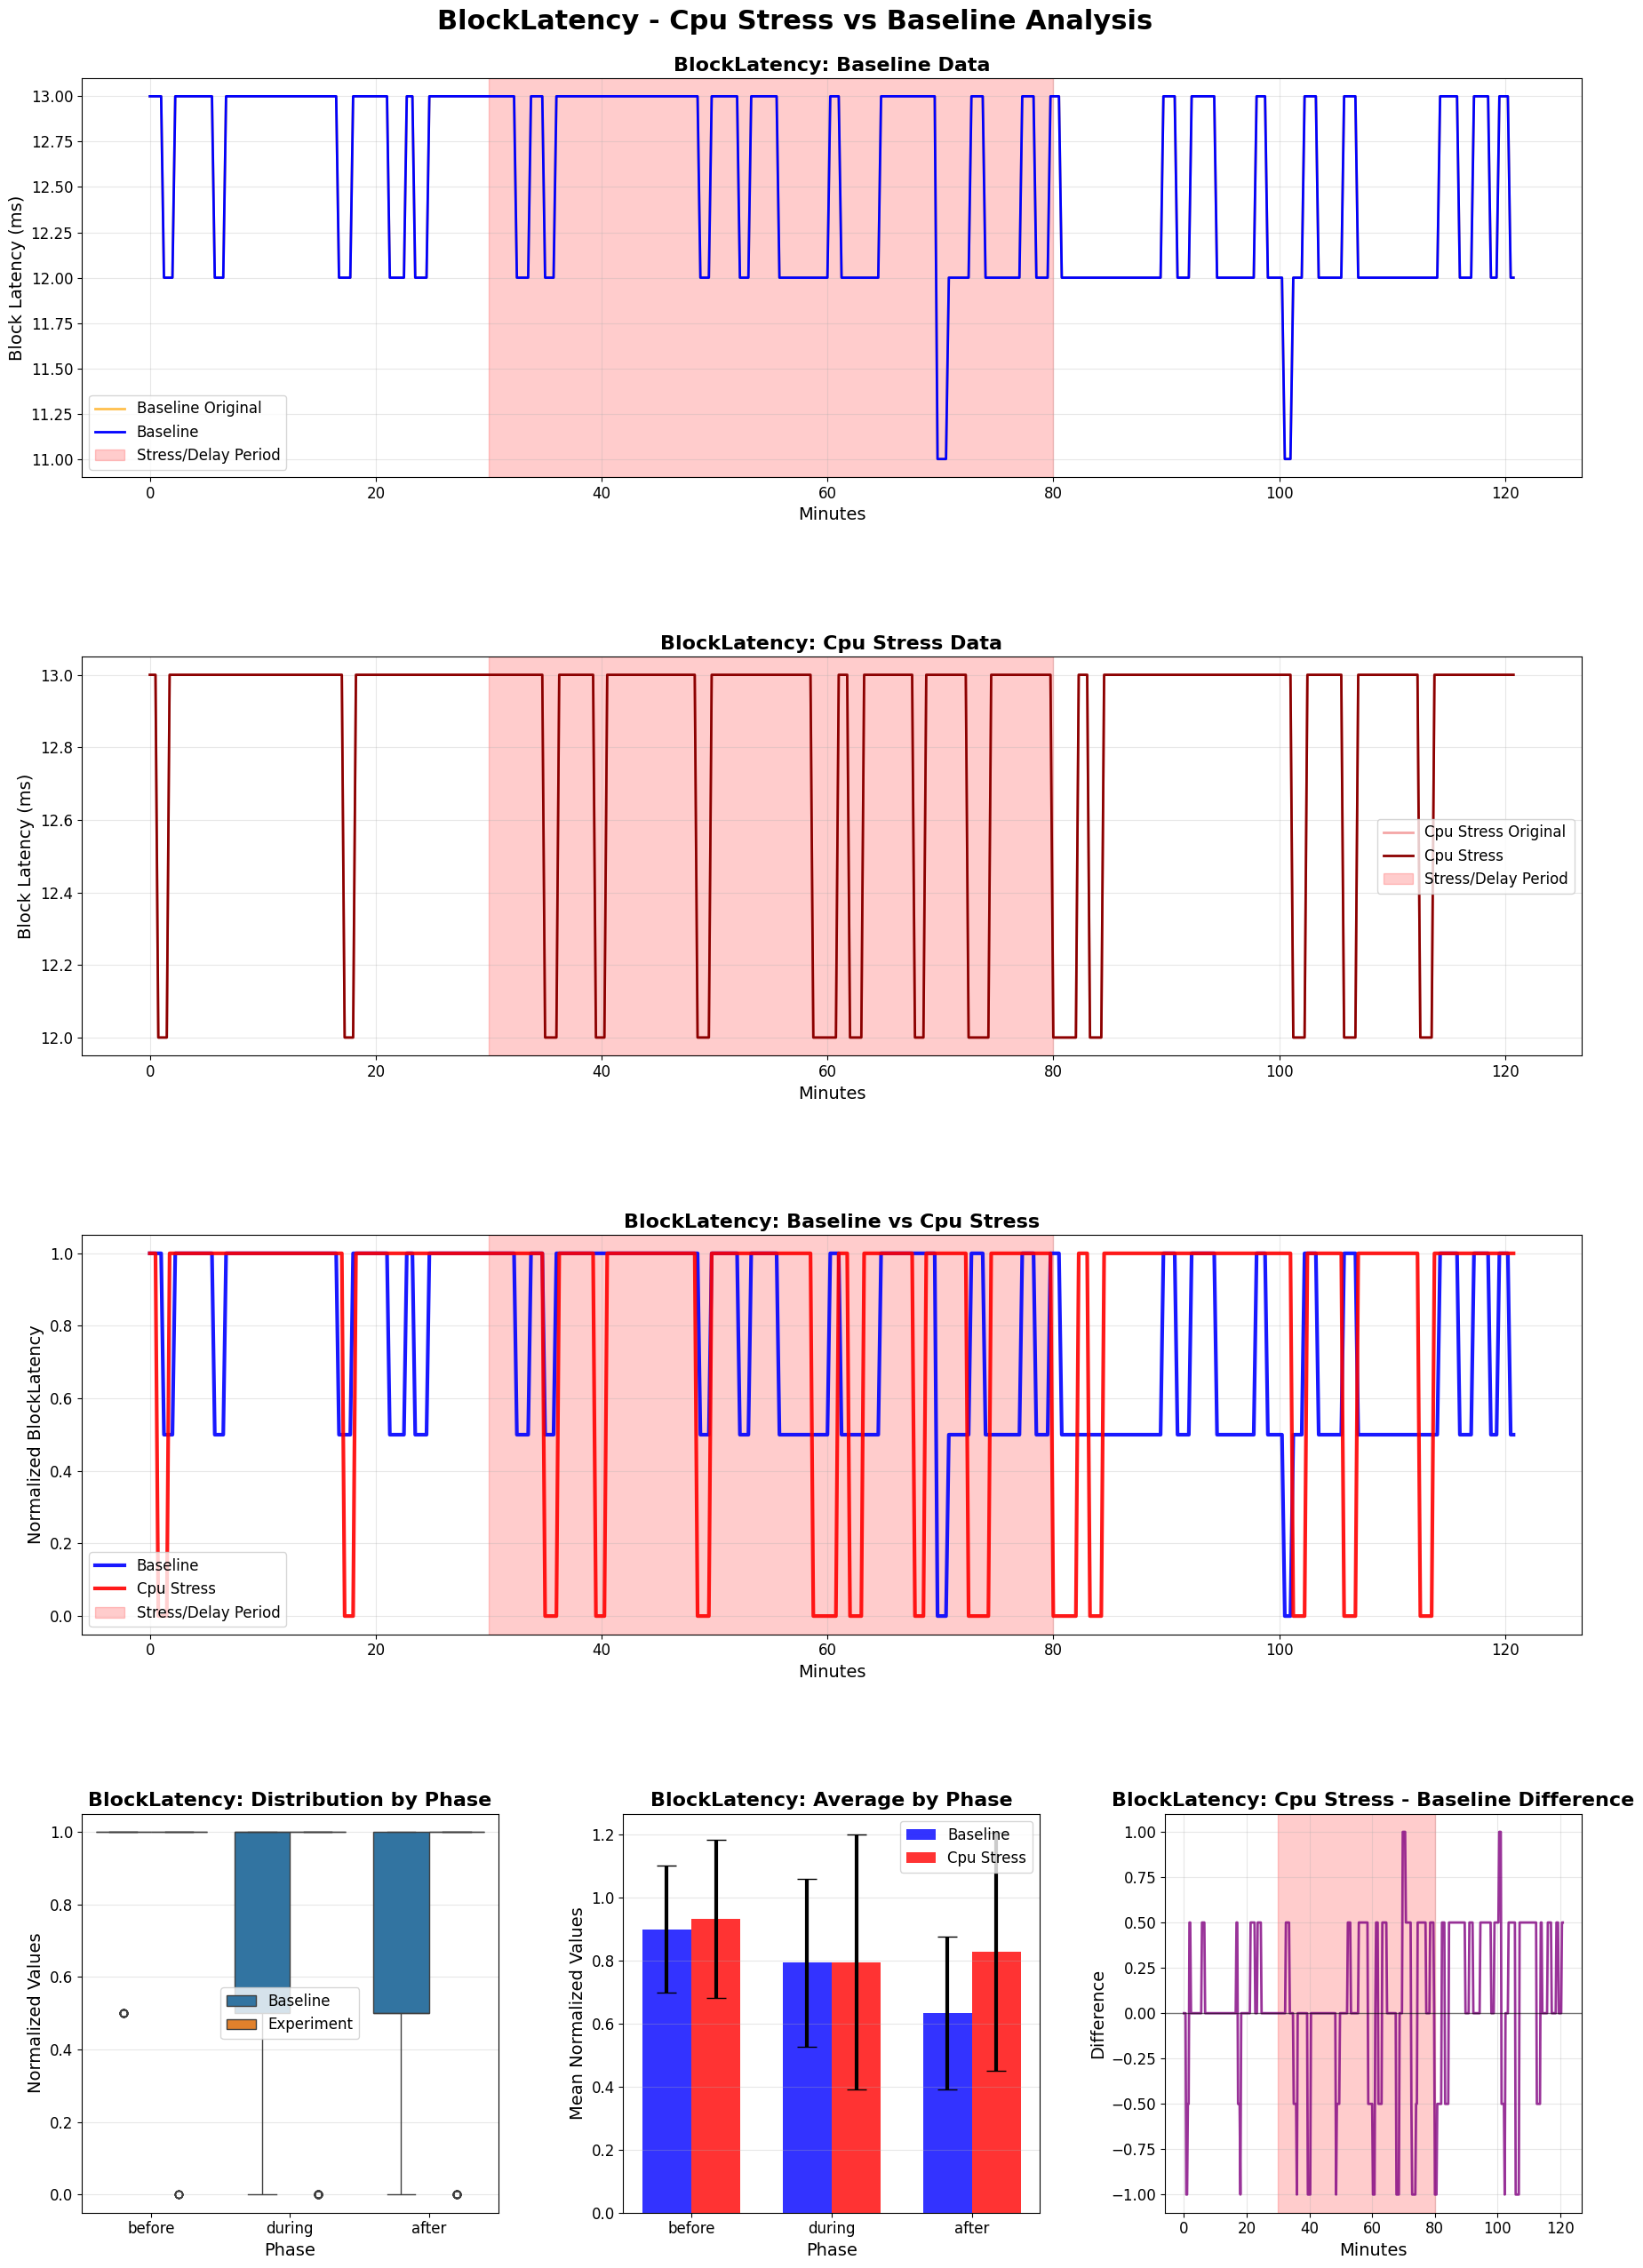


BLOCKLATENCY - CPU STRESS VS BASELINE ANALYSIS

BASELINE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.6350  0.2426  0.0  1.0
before  0.9000  0.2008  0.5  1.0
during  0.7935  0.2663  0.0  1.0

CPU STRESS STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.8282  0.3784  0.0  1.0
before  0.9333  0.2505  0.0  1.0
during  0.7960  0.4040  0.0  1.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -1.14, p=  0.2566 (NOT SIGNIFICANT)
  DURING  : t= -0.07, p=  0.9419 (NOT SIGNIFICANT)
  AFTER   : t= -5.49, p=  0.0000 (SIGNIFICANT)

CPU STRESS IMPACT:
  BEFORE  :   +3.70% (INCREASE)
  DURING  :   +0.31% (INCREASE)
  AFTER   :  +30.43% (INCREASE)

DISK I/O METRICS DETAILS:
  Metric: BlockLatency
  Metric type: Block Latency (ms)
  Columns analyzed: ['disk sda']
  Data points analyzed: 484

📊 Comparing BlockLatency: delay stress vs baseline


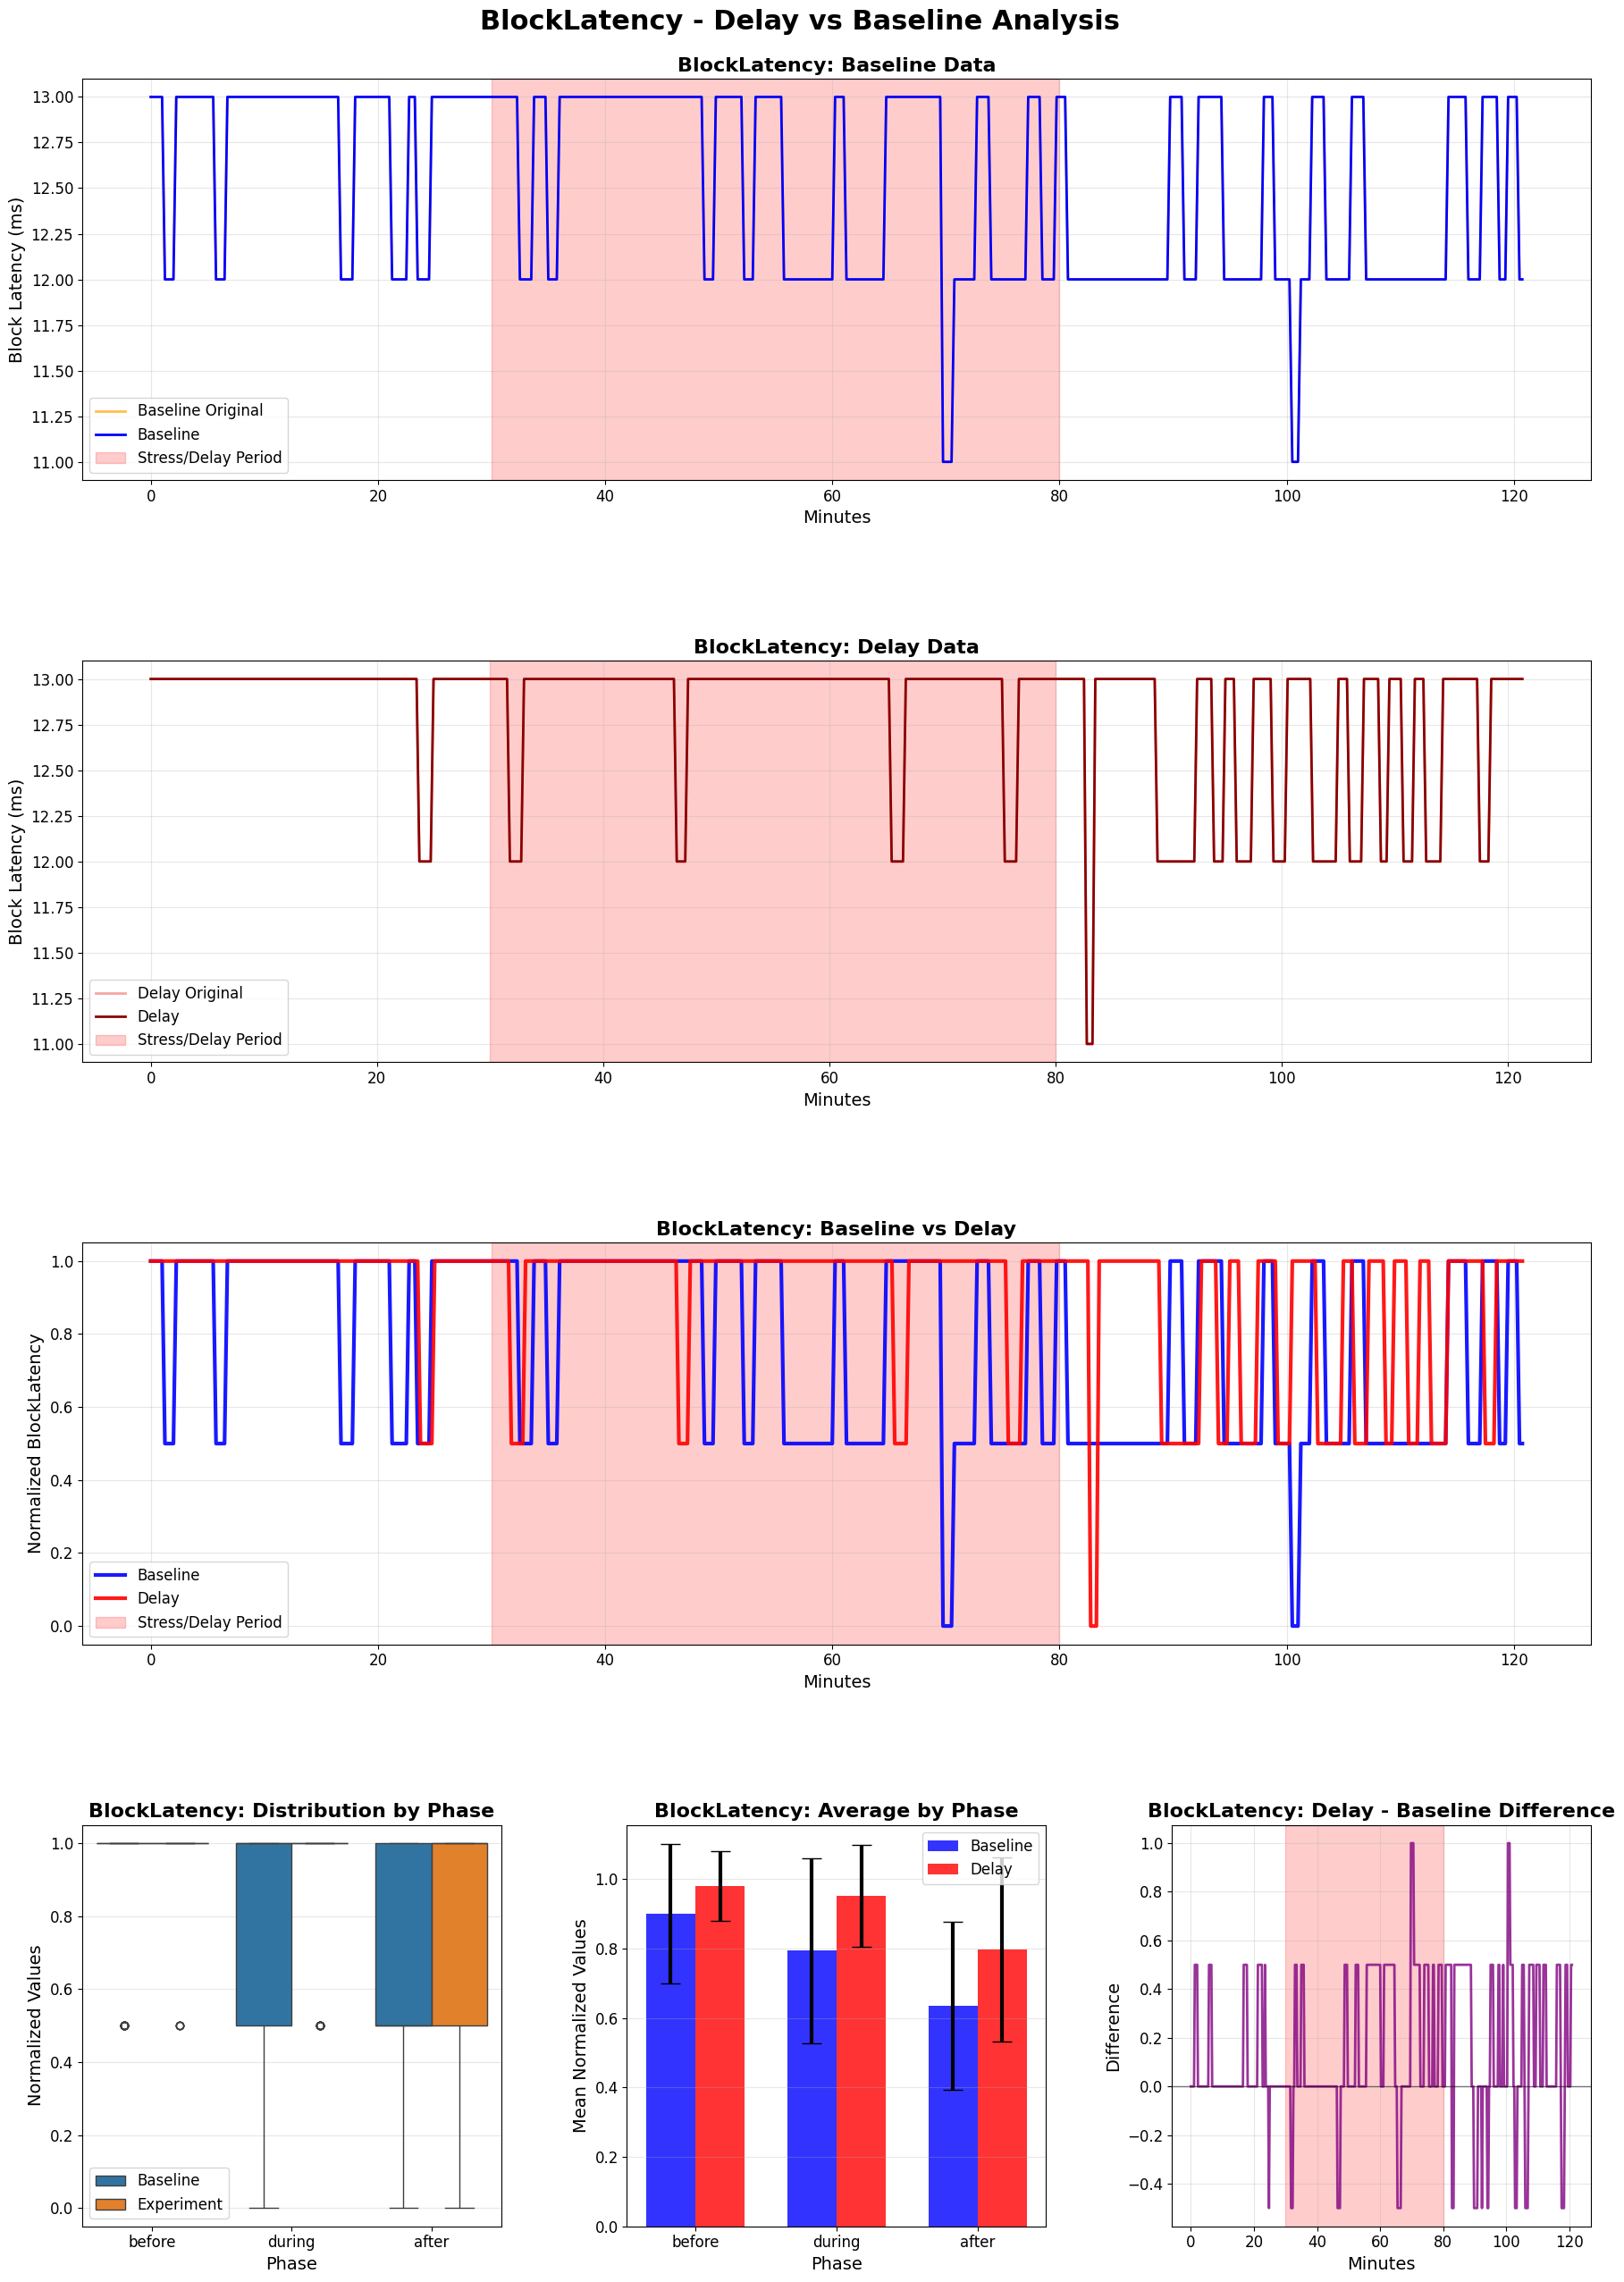


BLOCKLATENCY - DELAY VS BASELINE ANALYSIS

BASELINE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.6350  0.2426  0.0  1.0
before  0.9000  0.2008  0.5  1.0
during  0.7935  0.2663  0.0  1.0

DELAY STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.7975  0.2643  0.0  1.0
before  0.9792  0.1003  0.5  1.0
during  0.9527  0.1466  0.5  1.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -3.86, p=  0.0001 (SIGNIFICANT)
  DURING  : t= -7.42, p=  0.0000 (SIGNIFICANT)
  AFTER   : t= -5.79, p=  0.0000 (SIGNIFICANT)

DELAY IMPACT:
  BEFORE  :   +8.80% (INCREASE)
  DURING  :  +20.06% (INCREASE)
  AFTER   :  +25.60% (INCREASE)

DISK I/O METRICS DETAILS:
  Metric: BlockLatency
  Metric type: Block Latency (ms)
  Columns analyzed: ['disk sda']
  Data points analyzed: 484

📊 Comparing BlockLatency: mem_stress stress vs baseline


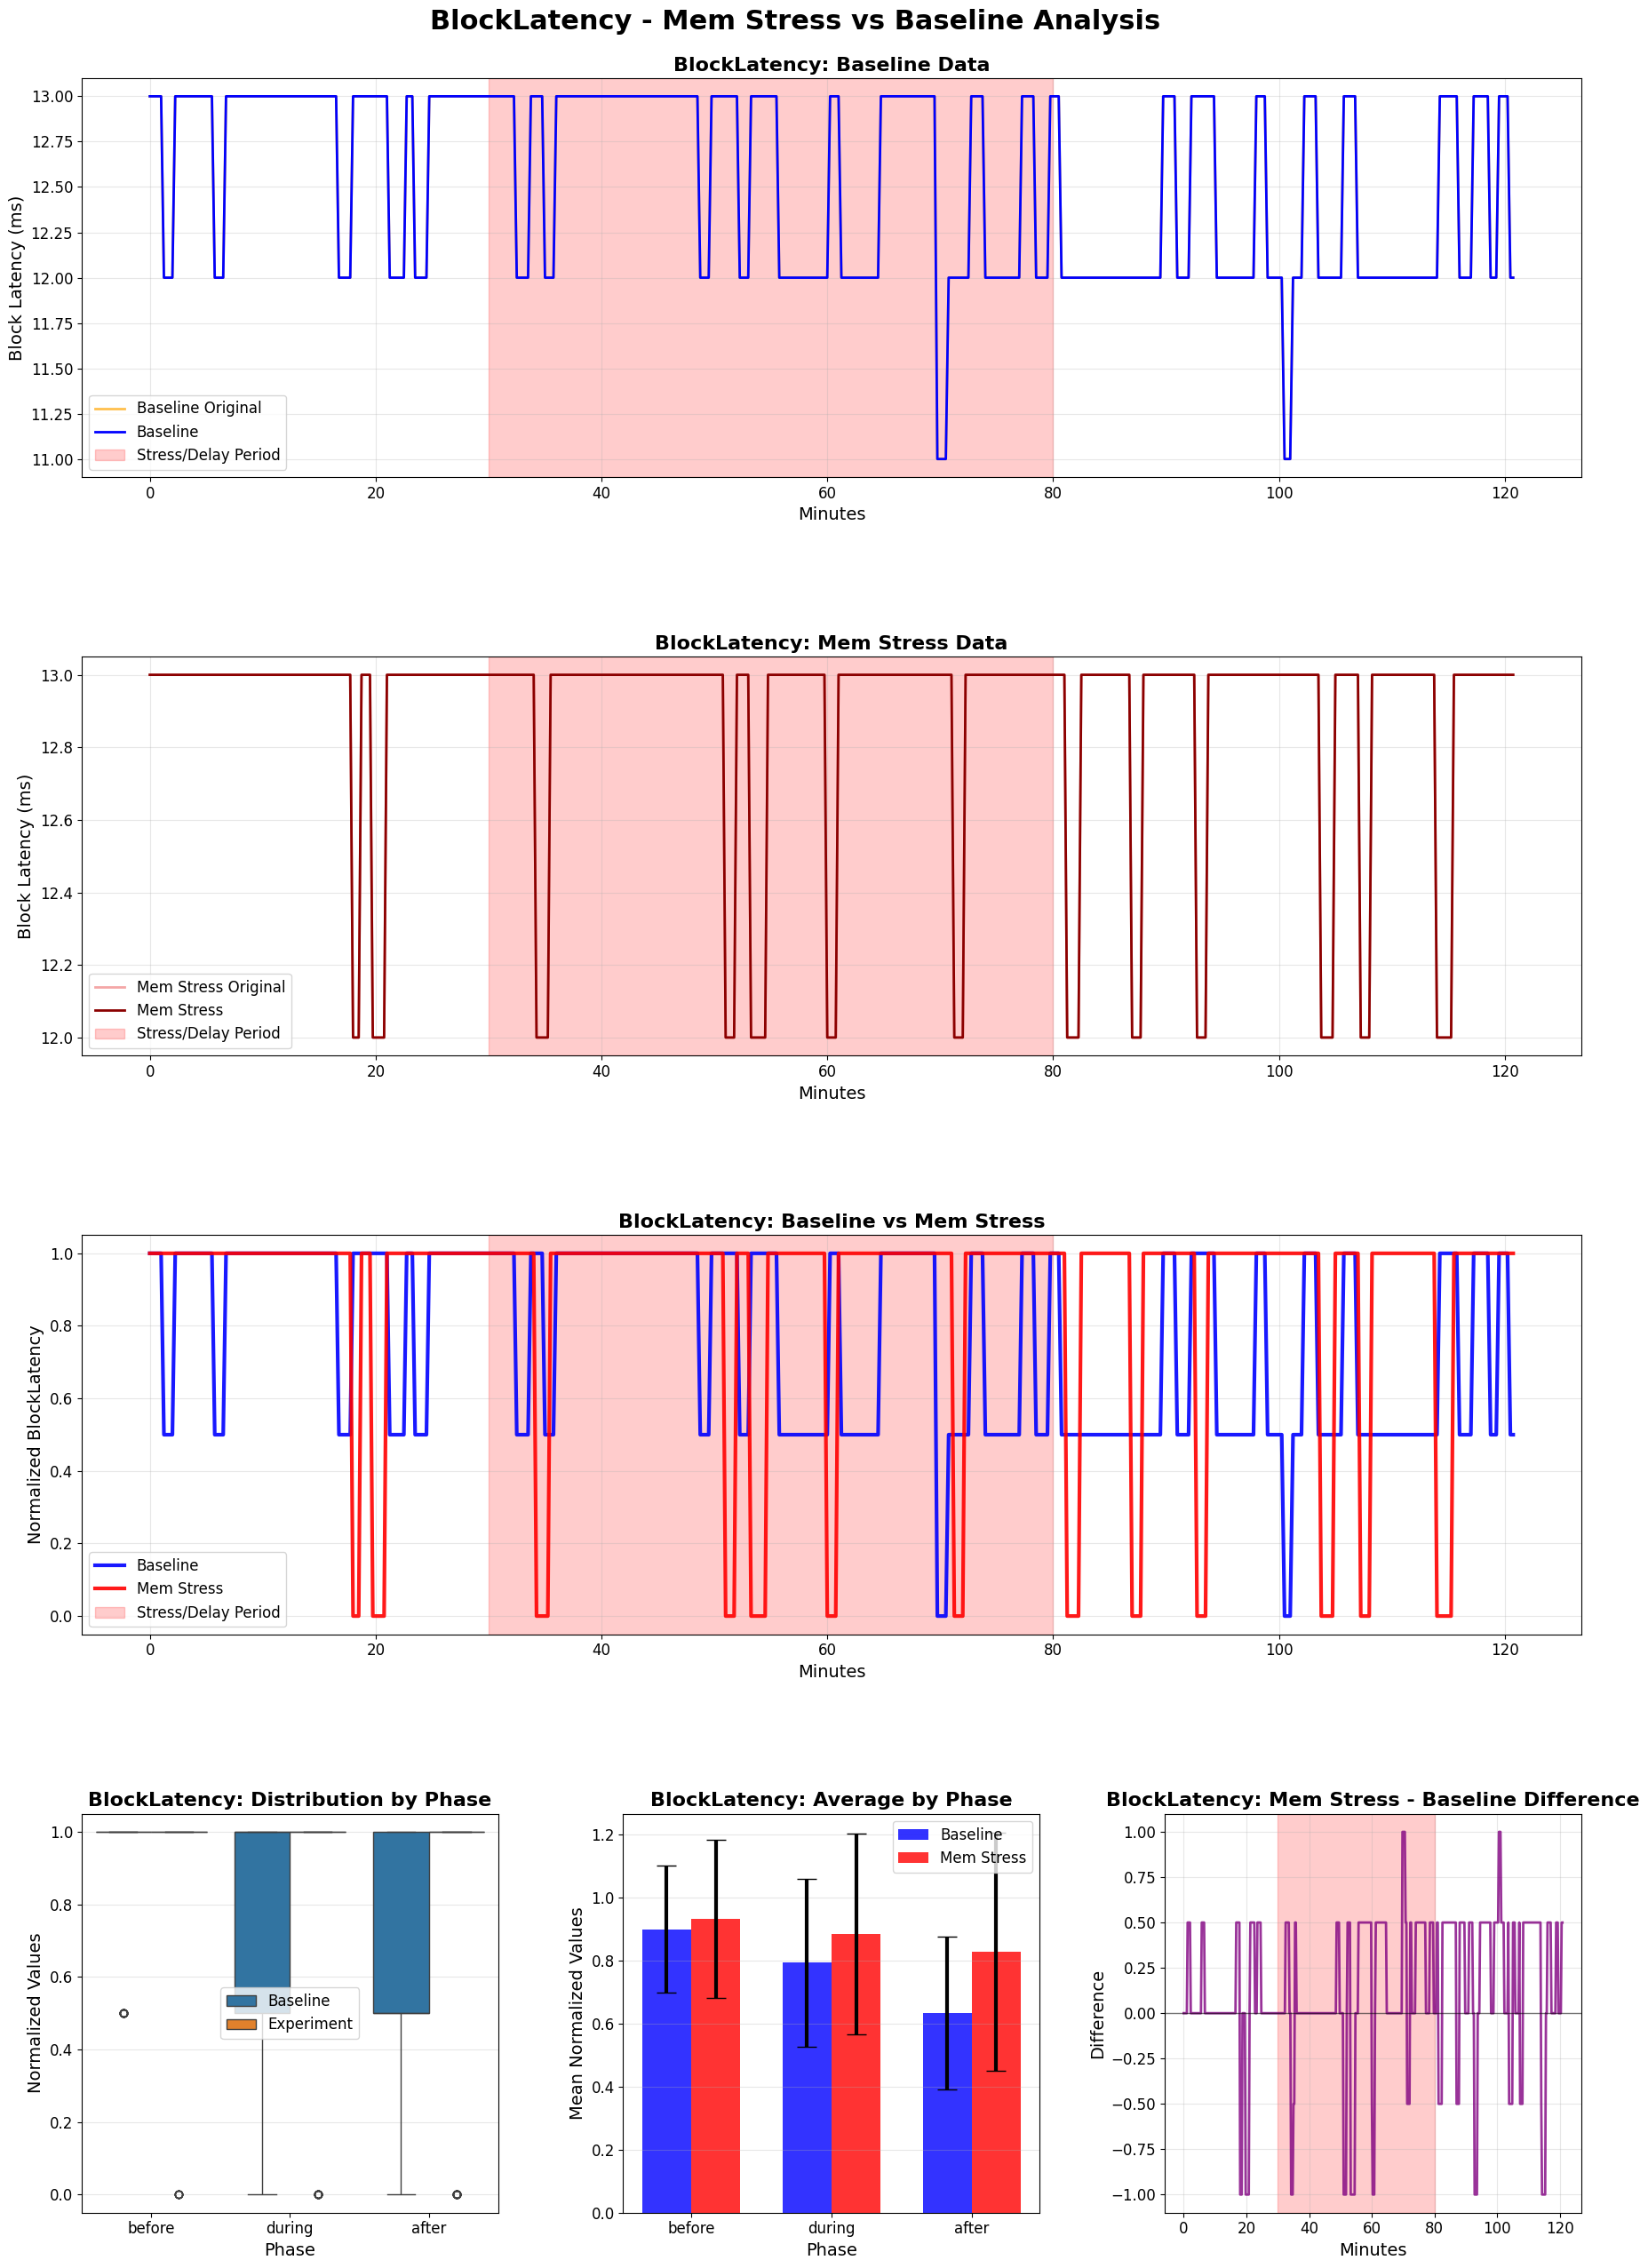


BLOCKLATENCY - MEM STRESS VS BASELINE ANALYSIS

BASELINE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.6350  0.2426  0.0  1.0
before  0.9000  0.2008  0.5  1.0
during  0.7935  0.2663  0.0  1.0

MEM STRESS STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.8282  0.3784  0.0  1.0
before  0.9333  0.2505  0.0  1.0
during  0.8856  0.3191  0.0  1.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -1.14, p=  0.2566 (NOT SIGNIFICANT)
  DURING  : t= -3.14, p=  0.0018 (SIGNIFICANT)
  AFTER   : t= -5.49, p=  0.0000 (SIGNIFICANT)

MEM STRESS IMPACT:
  BEFORE  :   +3.70% (INCREASE)
  DURING  :  +11.60% (INCREASE)
  AFTER   :  +30.43% (INCREASE)

DISK I/O METRICS DETAILS:
  Metric: BlockLatency
  Metric type: Block Latency (ms)
  Columns analyzed: ['disk sda']
  Data points analyzed: 484

📊 Comparing BlockLatency: net_loss stress vs baseline


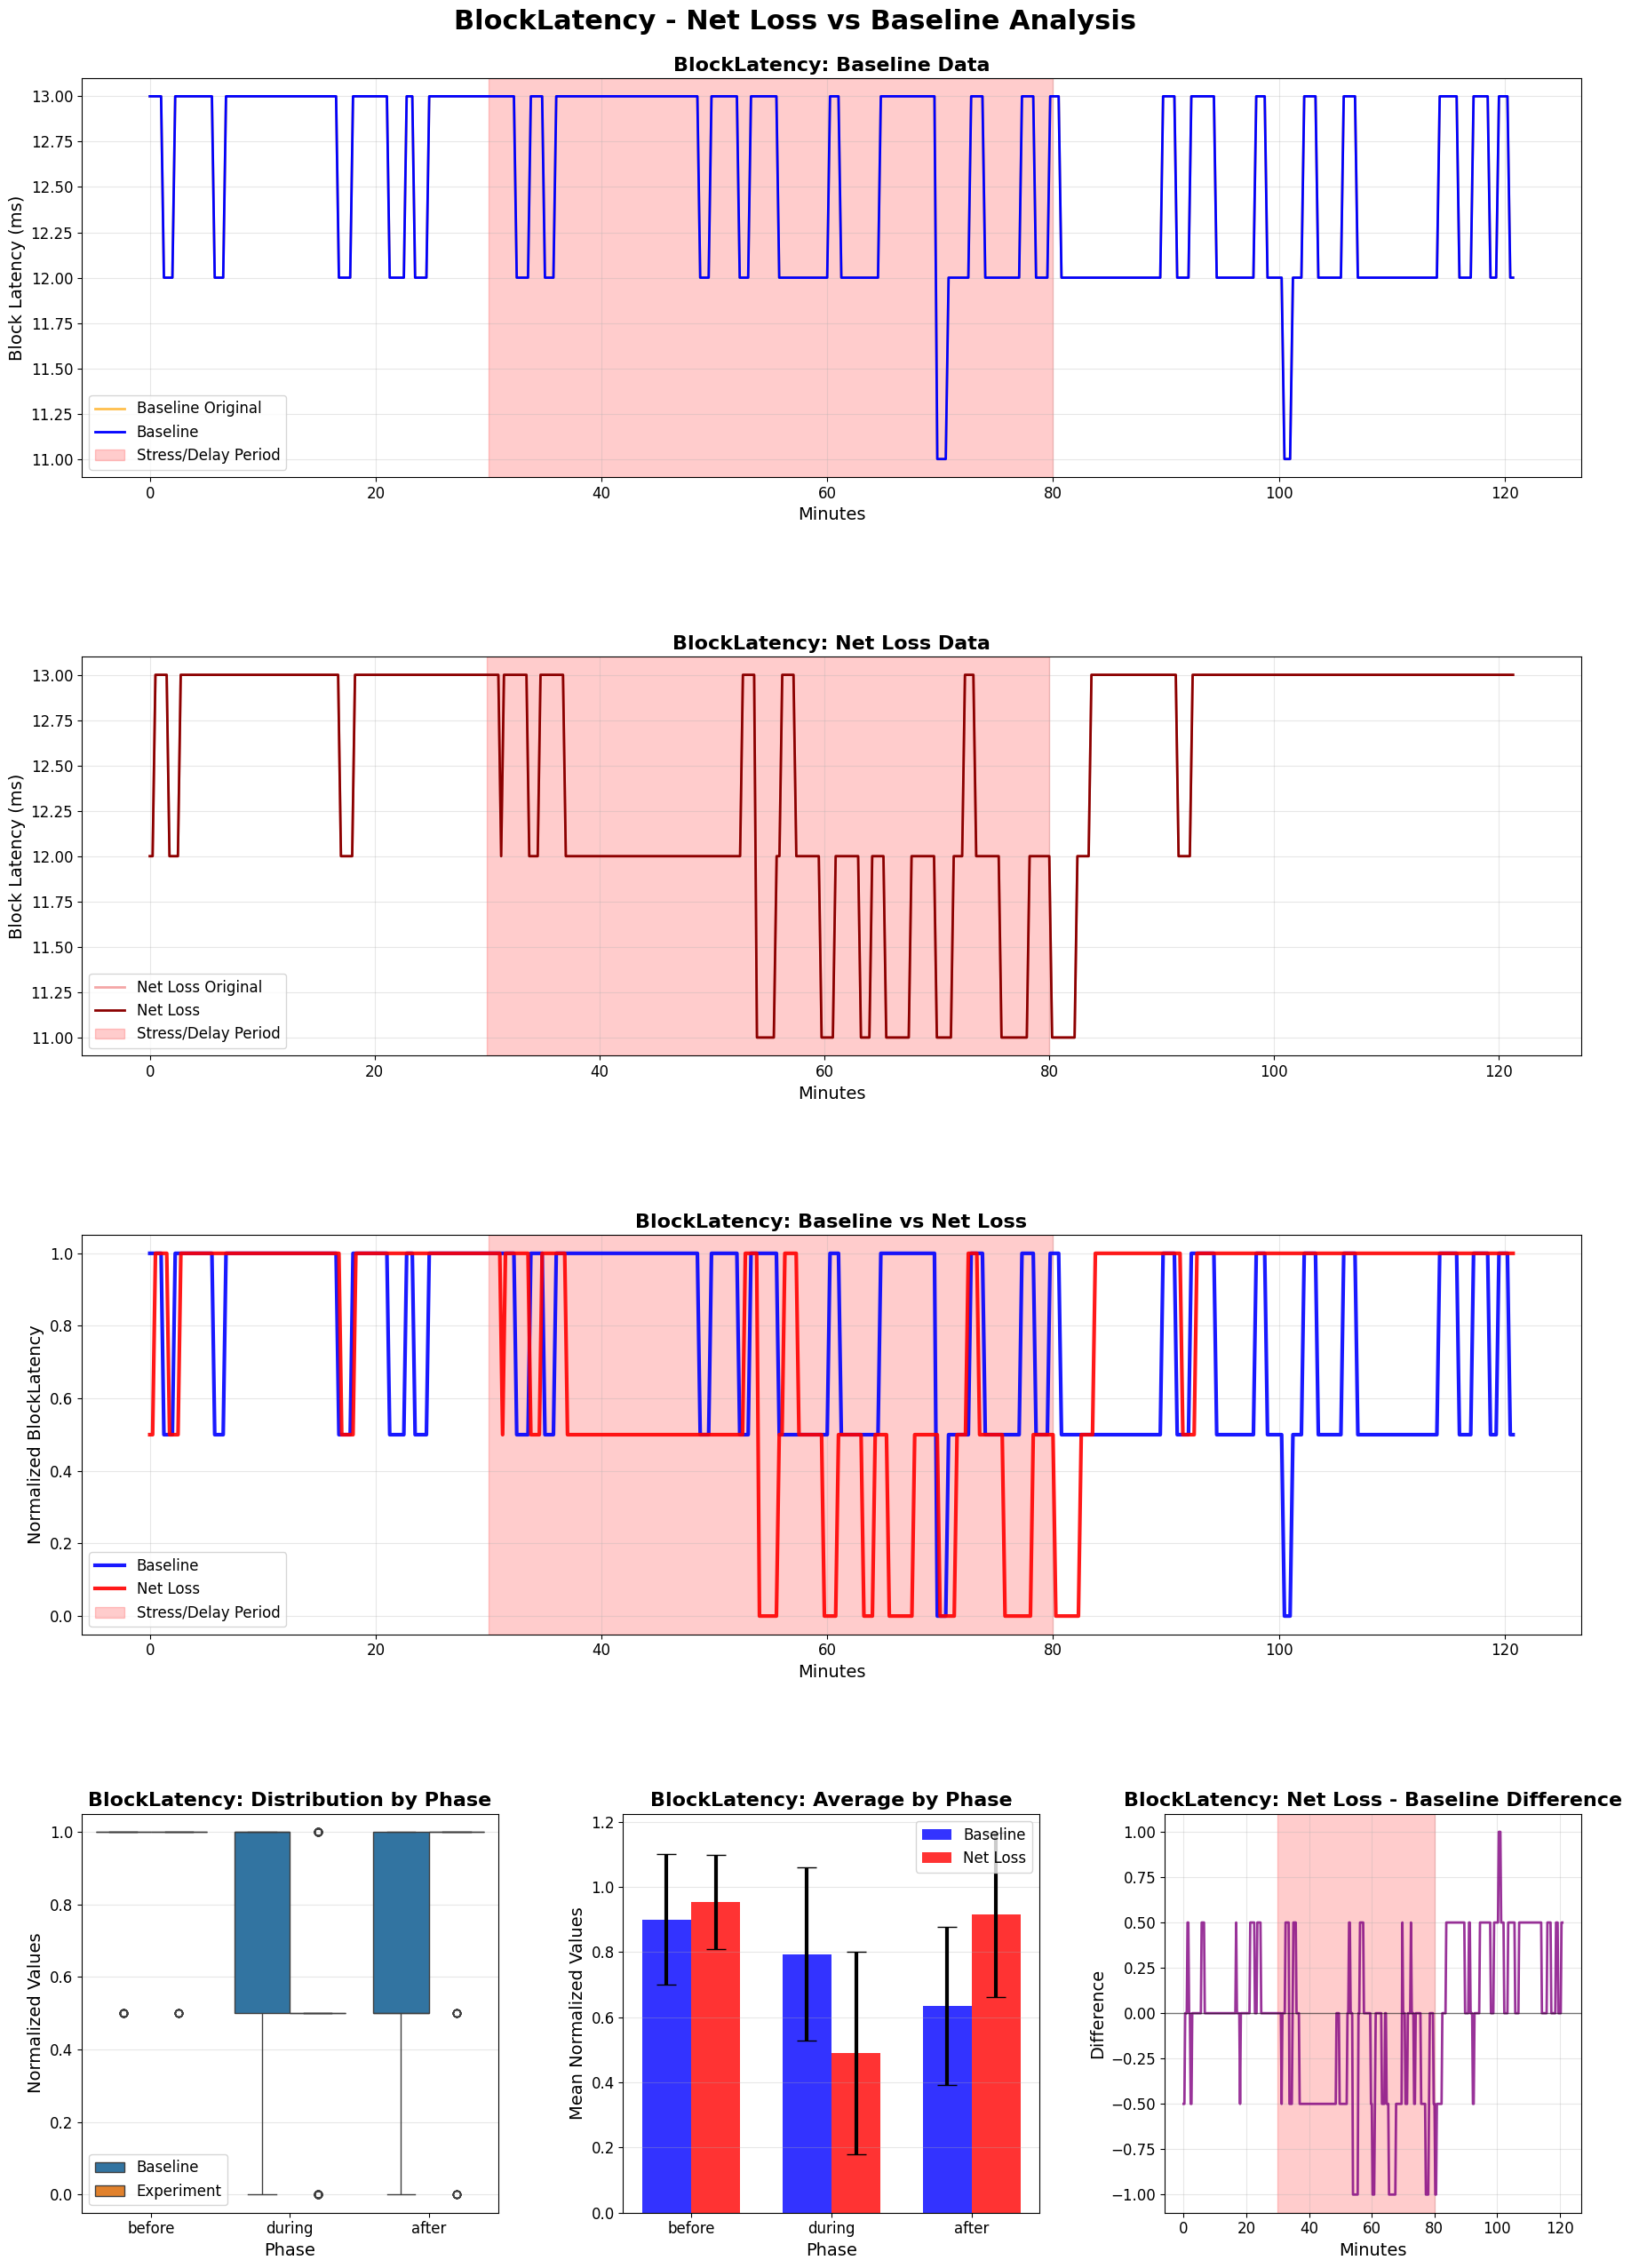


BLOCKLATENCY - NET LOSS VS BASELINE ANALYSIS

BASELINE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.6350  0.2426  0.0  1.0
before  0.9000  0.2008  0.5  1.0
during  0.7935  0.2663  0.0  1.0

NET LOSS STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.9141  0.2521  0.0  1.0
before  0.9542  0.1449  0.5  1.0
during  0.4900  0.3121  0.0  1.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.40, p=  0.0173 (SIGNIFICANT)
  DURING  : t= 10.49, p=  0.0000 (SIGNIFICANT)
  AFTER   : t=-10.19, p=  0.0000 (SIGNIFICANT)

NET LOSS IMPACT:
  BEFORE  :   +6.02% (INCREASE)
  DURING  :  -38.24% (DECREASE)
  AFTER   :  +43.96% (INCREASE)

DISK I/O METRICS DETAILS:
  Metric: BlockLatency
  Metric type: Block Latency (ms)
  Columns analyzed: ['disk sda']
  Data points analyzed: 484

🔍 Analyzing ReadBytes...

📊 Comparing ReadBytes: cpu_stress stress vs baseline


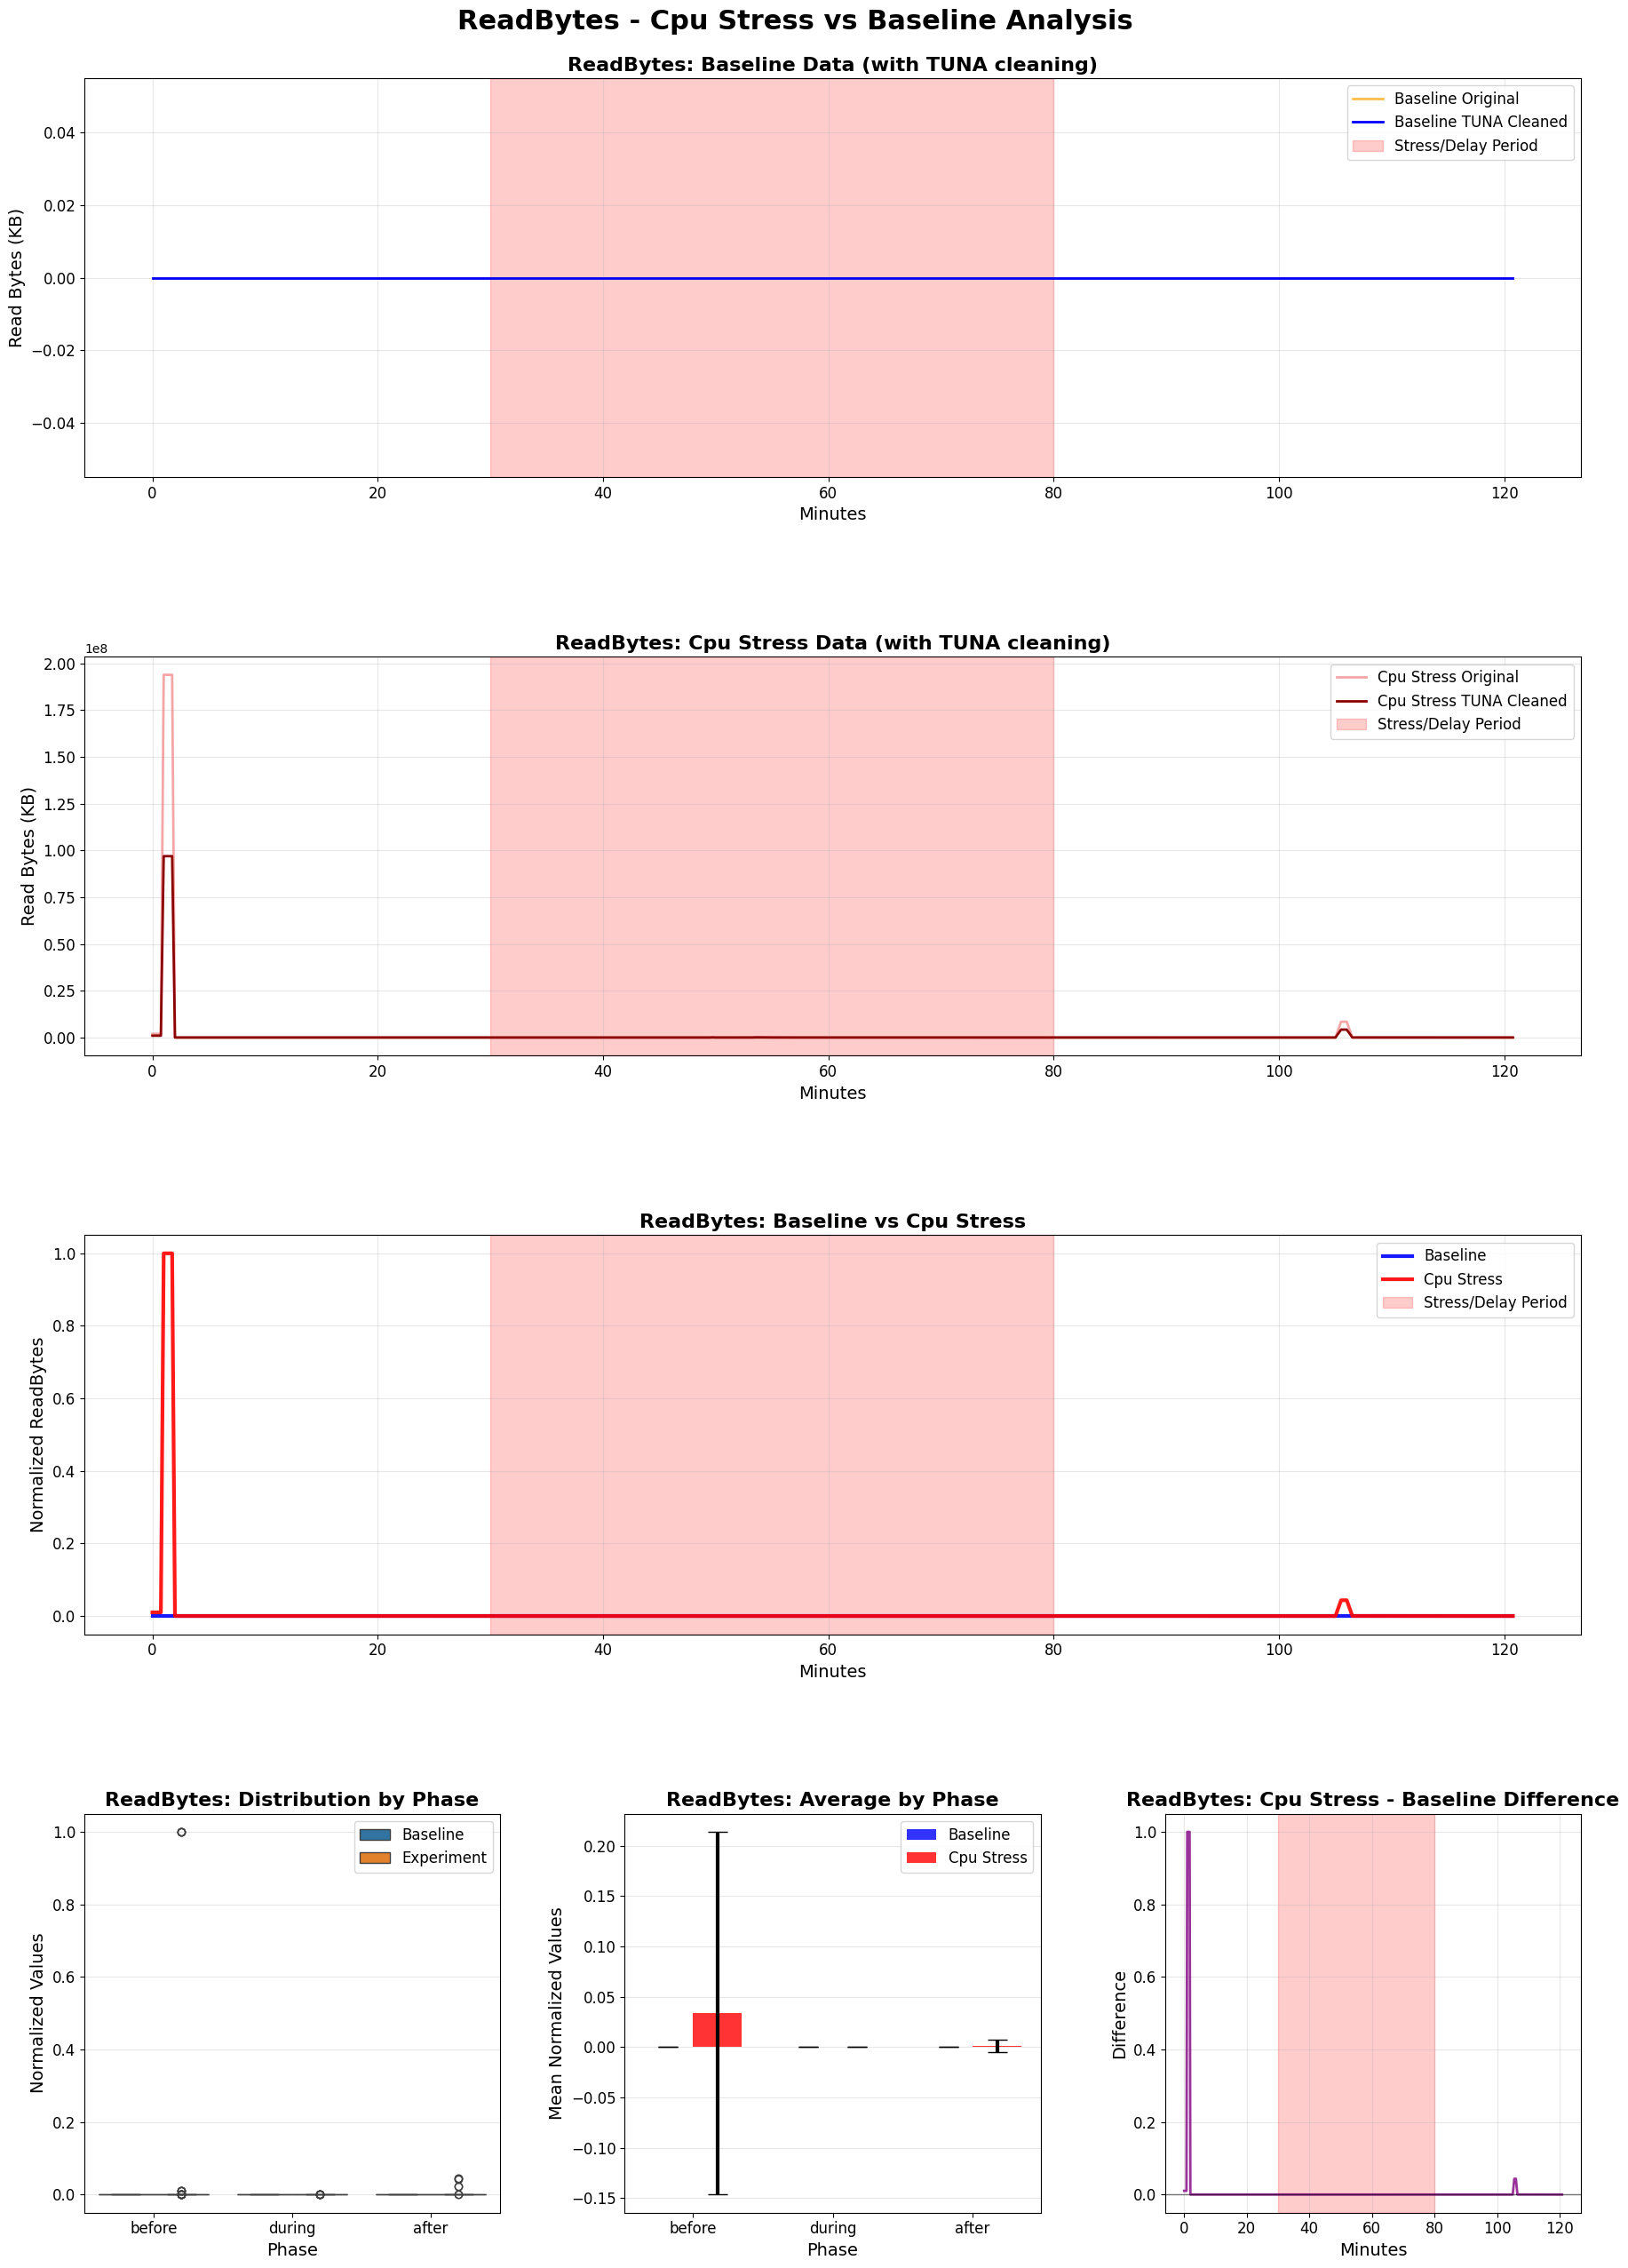


READBYTES - CPU STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  CPU STRESS: 73 outliers removed
    Noise Reduction: 50.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0  0.0  0.0
before   0.0  0.0  0.0  0.0
during   0.0  0.0  0.0  0.0

CPU STRESS STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.0011  0.0063  0.0  0.0437
before  0.0337  0.1802  0.0  1.0000
during  0.0000  0.0001  0.0  0.0003

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.05, p=  0.0417 (SIGNIFICANT)
  DURING  : t= -2.69, p=  0.0075 (SIGNIFICANT)
  AFTER   : t= -2.17, p=  0.0309 (SIGNIFICANT)

CPU STRESS IMPACT:
  BEFORE  :   +0.00% (NO CHANGE)
  DURING  :   +0.00% (NO CHANGE)
  AFTER   :   +0.00% (NO CHANGE)

DISK I/O METRICS DETAILS:
  Metric: ReadBytes
  Metric type: Read Bytes (KB)
  Columns analyzed

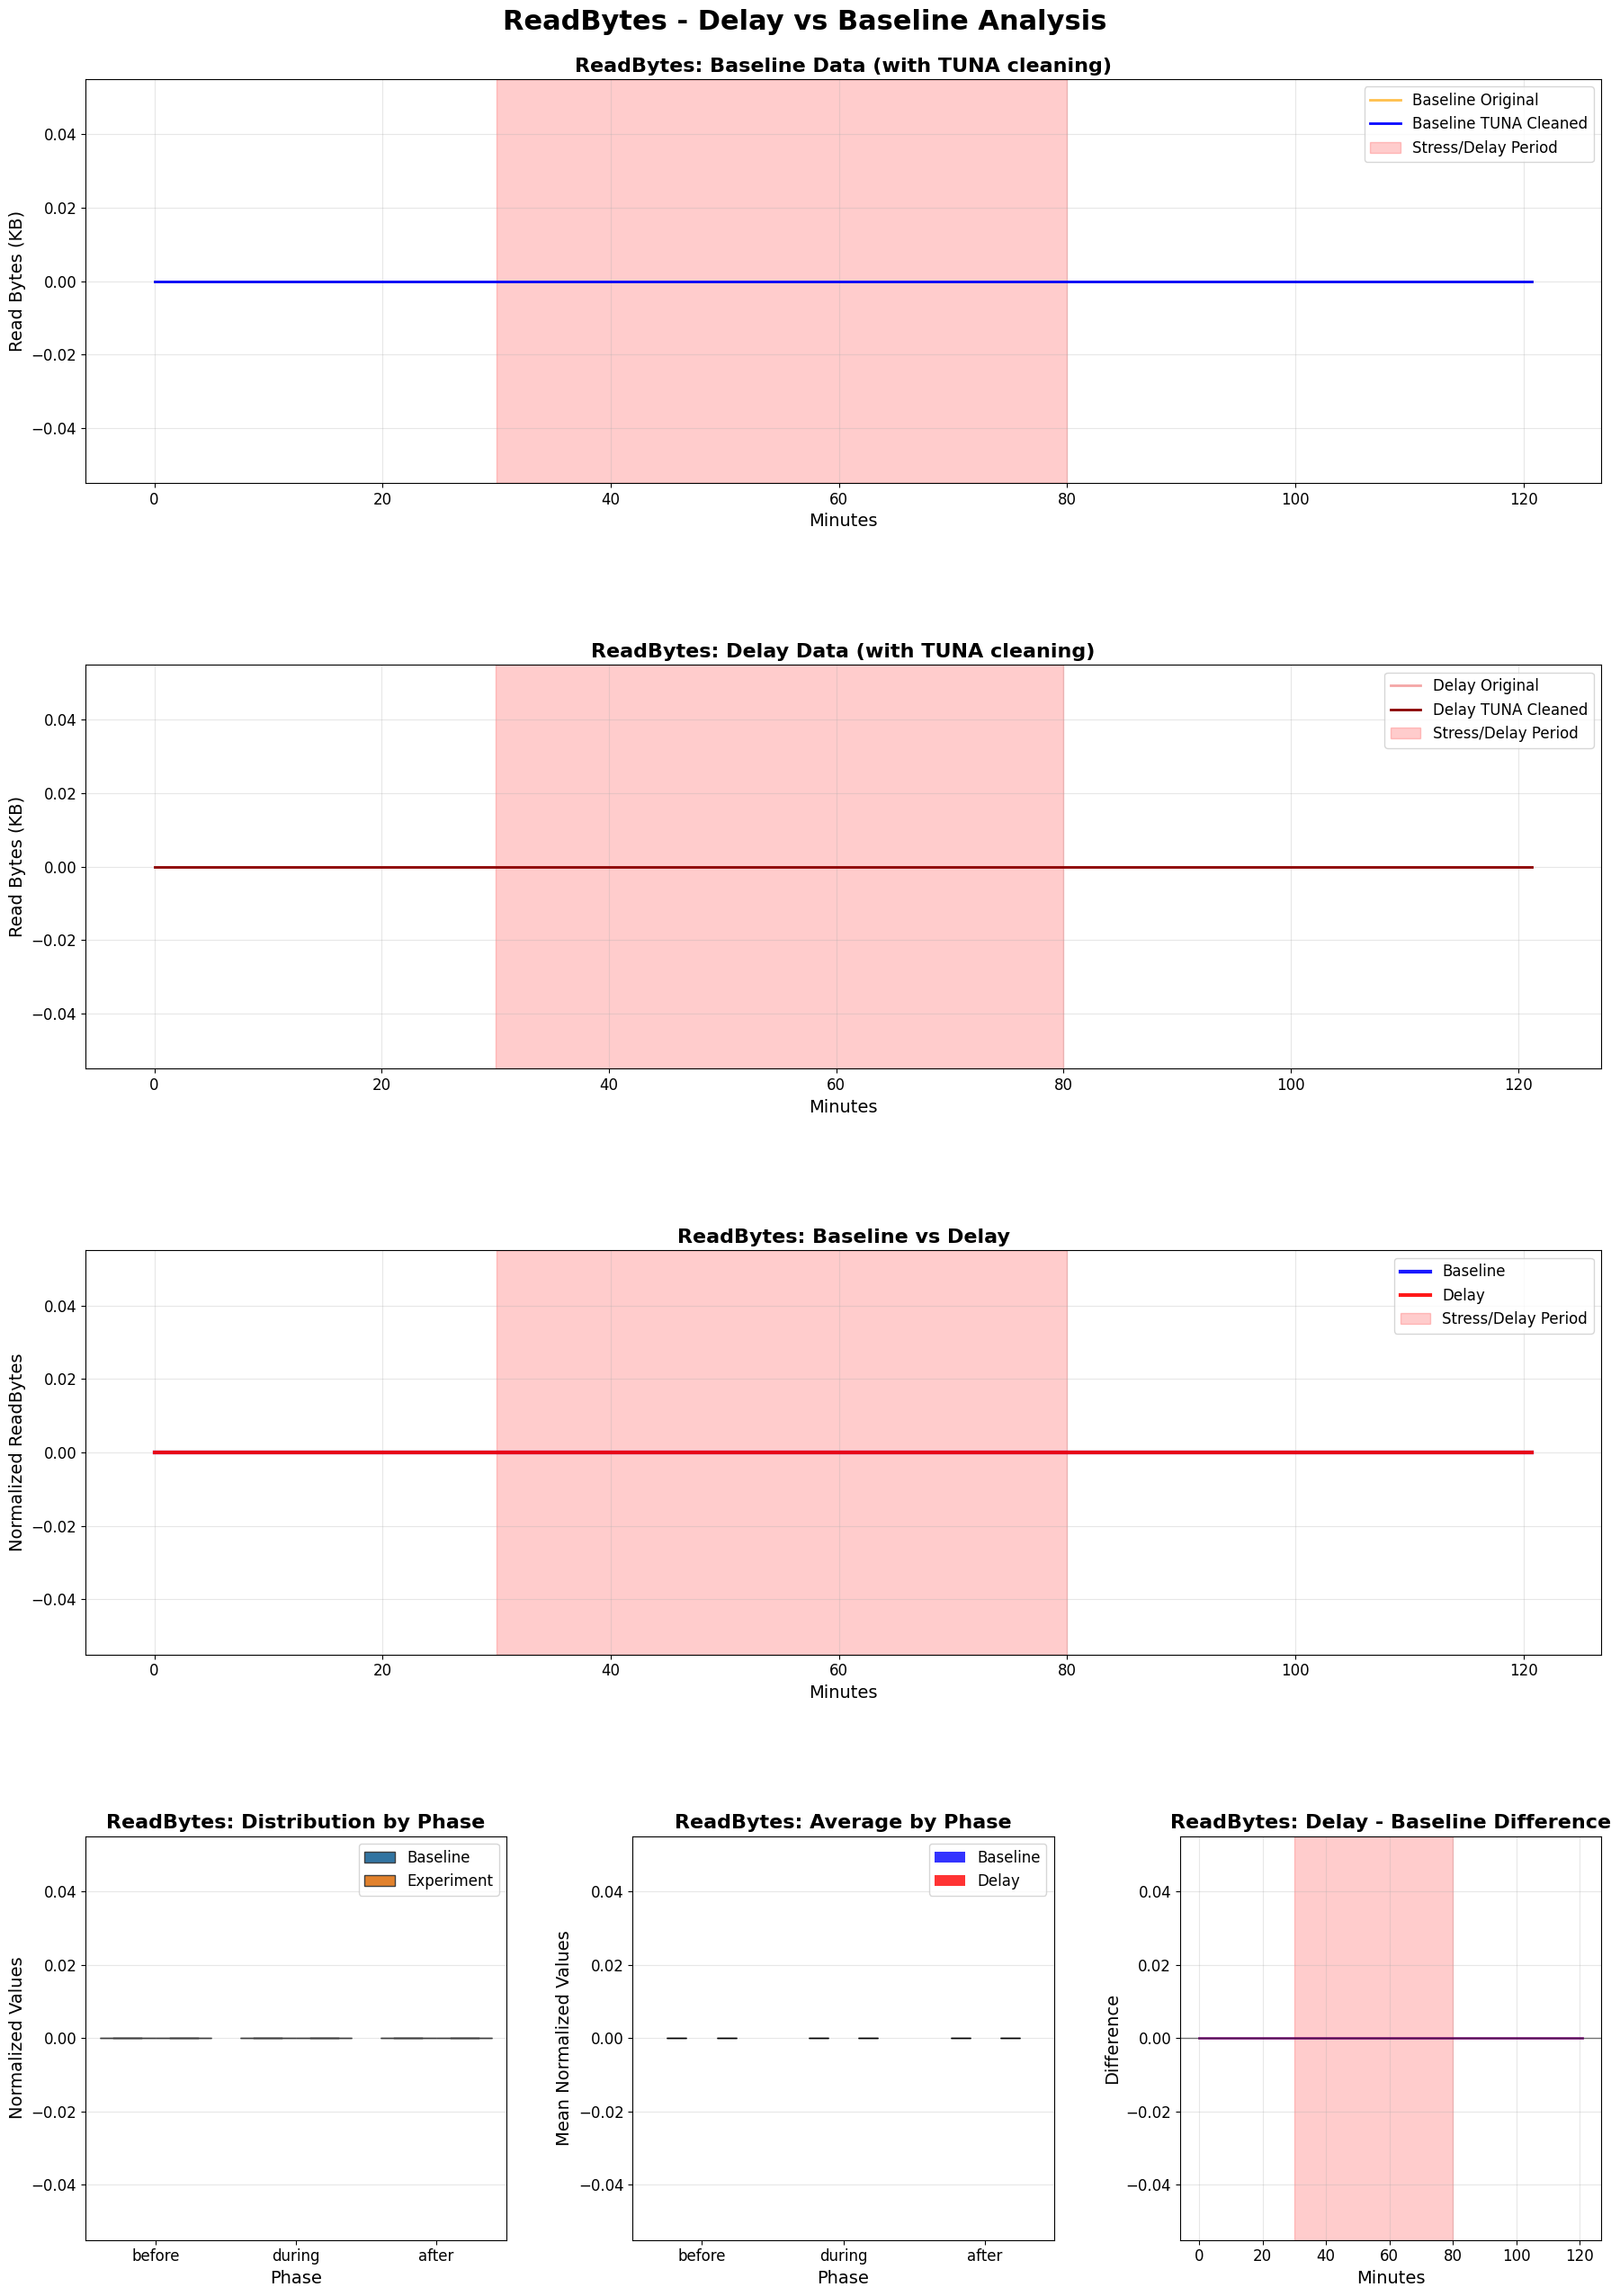


READBYTES - DELAY VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  DELAY: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0  0.0  0.0
before   0.0  0.0  0.0  0.0
during   0.0  0.0  0.0  0.0

DELAY STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0  0.0  0.0
before   0.0  0.0  0.0  0.0
during   0.0  0.0  0.0  0.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=   nan, p=     nan (NOT SIGNIFICANT)
  DURING  : t=   nan, p=     nan (NOT SIGNIFICANT)
  AFTER   : t=   nan, p=     nan (NOT SIGNIFICANT)

DELAY IMPACT:
  BEFORE  :   +0.00% (NO CHANGE)
  DURING  :   +0.00% (NO CHANGE)
  AFTER   :   +0.00% (NO CHANGE)

DISK I/O METRICS DETAILS:
  Metric: ReadBytes
  Metric type: Read Bytes (KB)
  Columns analyzed: ['openeuler-home', 'openeuler-root', 'openeuler-

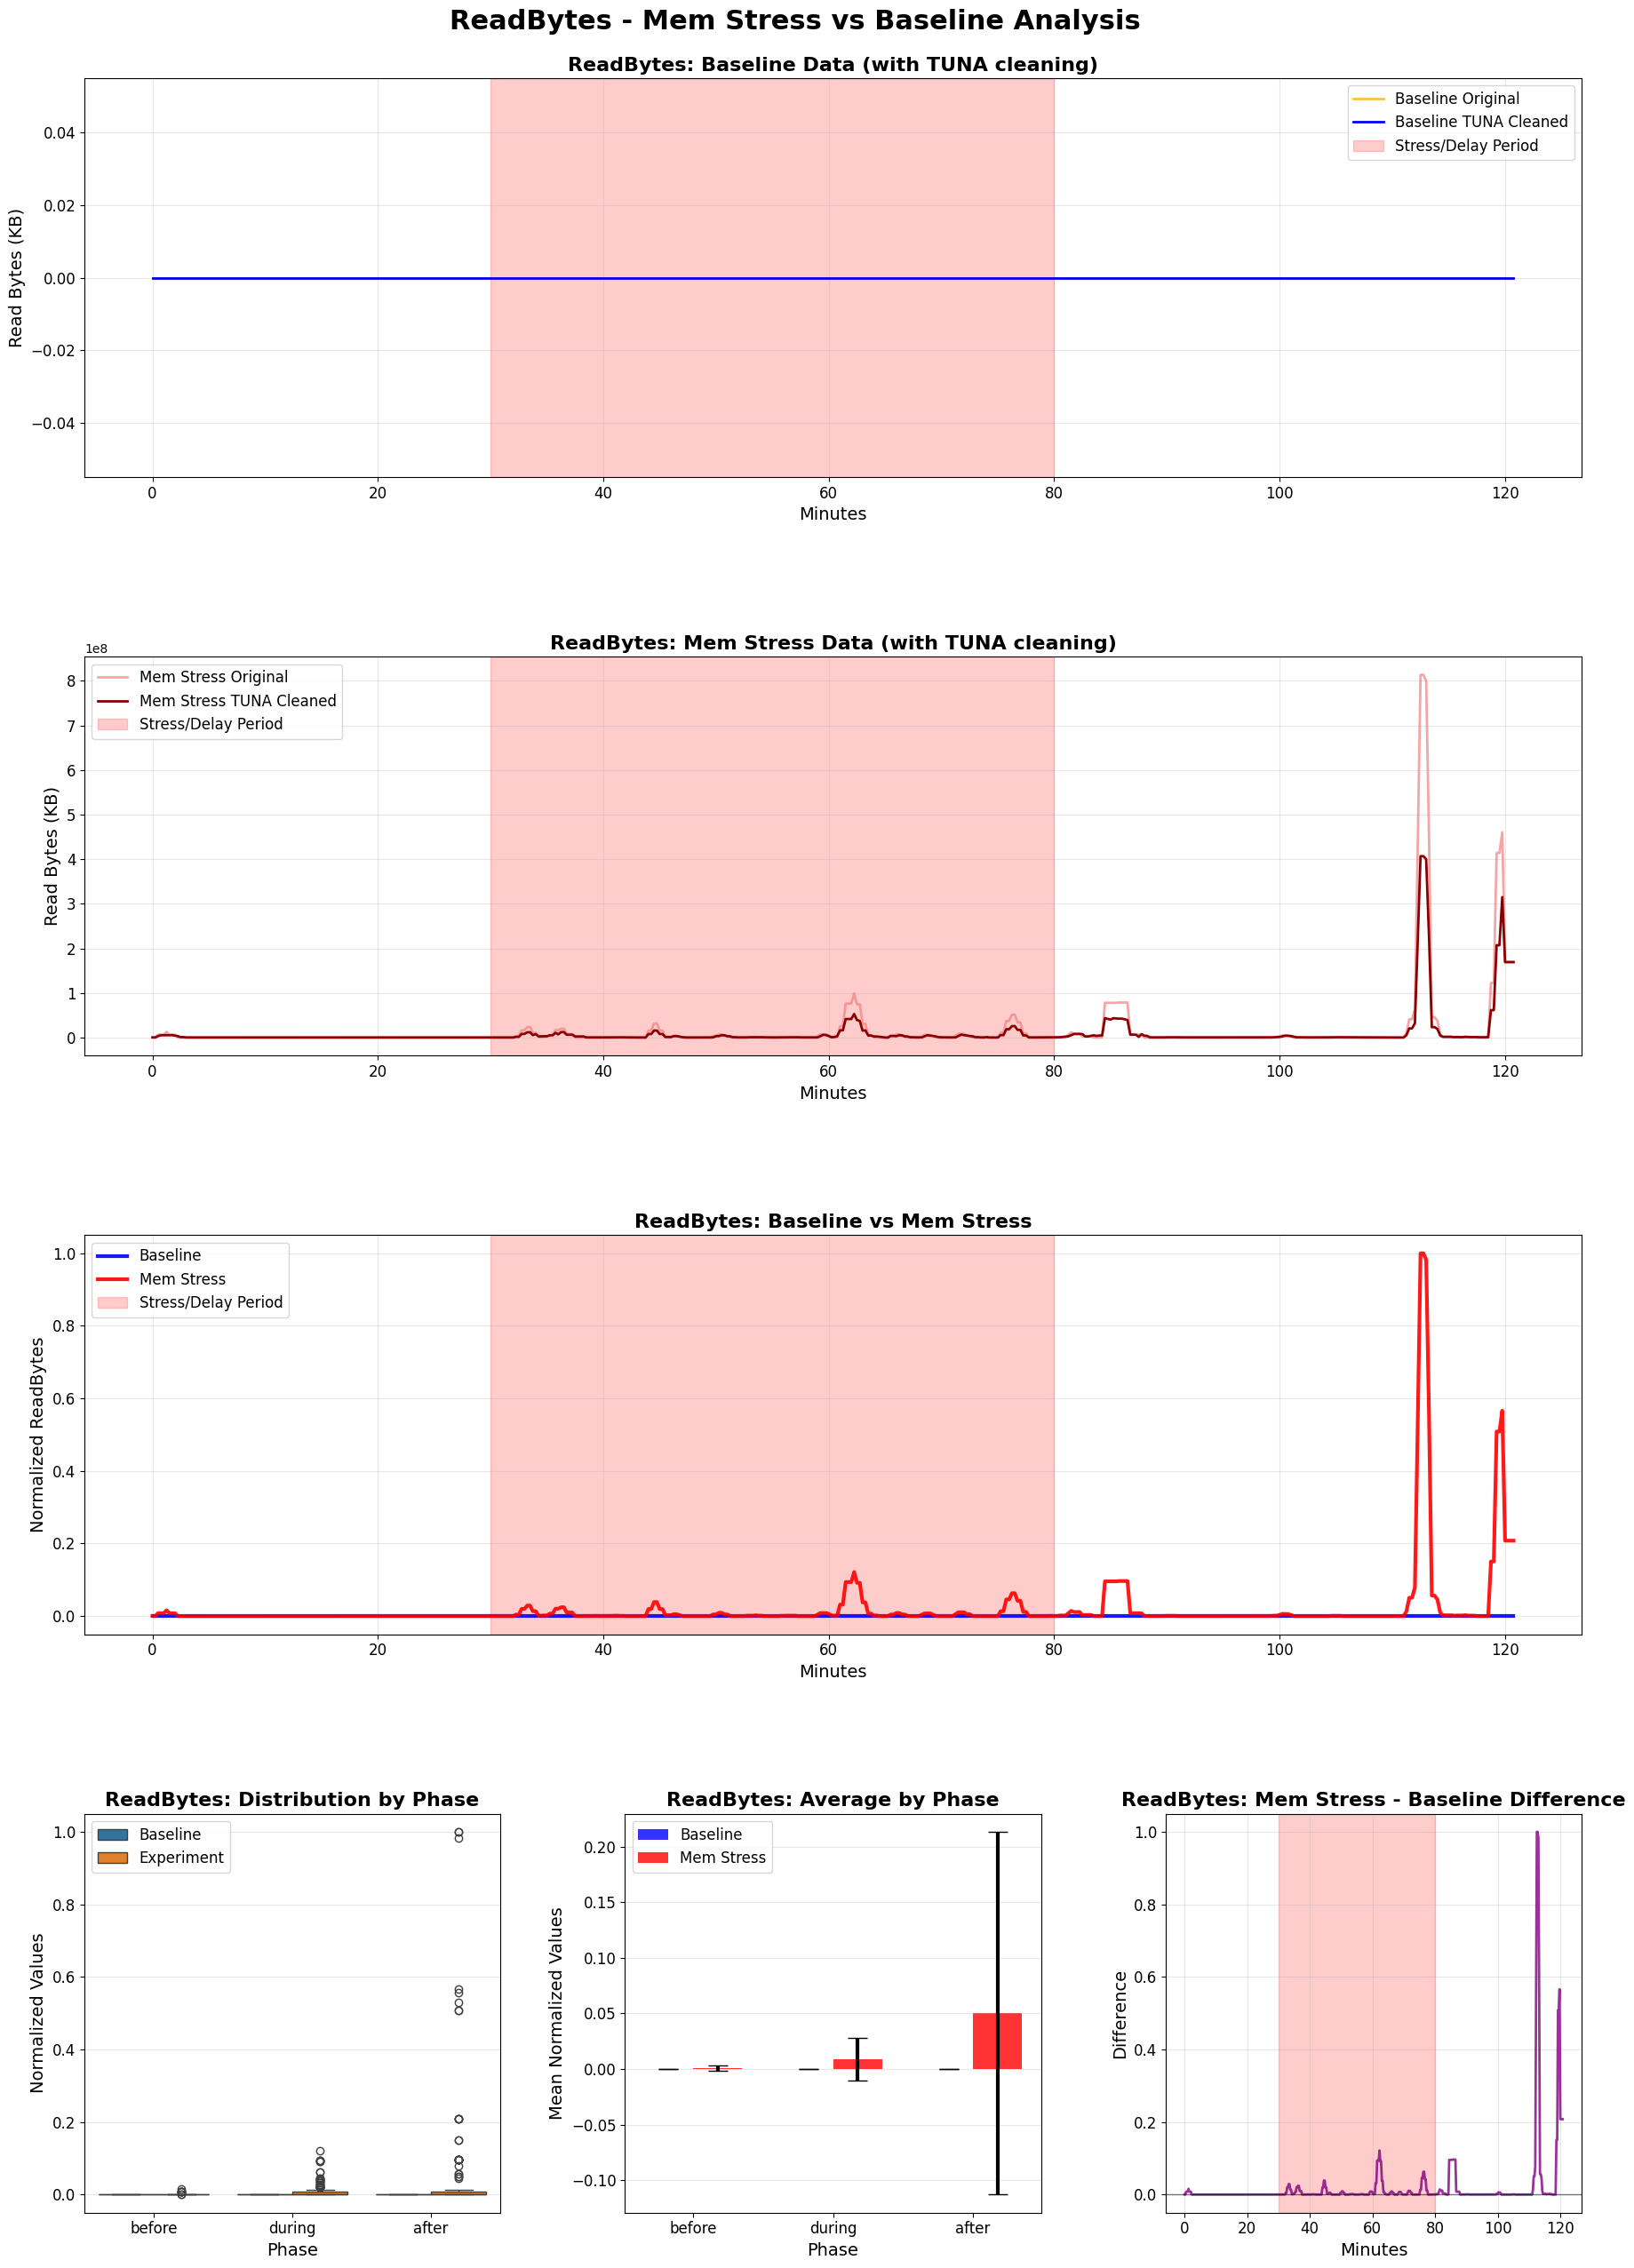


READBYTES - MEM STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  MEM STRESS: 296 outliers removed
    Noise Reduction: 46.1%, Correlation: 0.981
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0  0.0  0.0
before   0.0  0.0  0.0  0.0
during   0.0  0.0  0.0  0.0

MEM STRESS STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.0501  0.1630  0.0  1.0000
before  0.0005  0.0022  0.0  0.0157
during  0.0086  0.0194  0.0  0.1214

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.61, p=  0.0097 (SIGNIFICANT)
  DURING  : t= -6.32, p=  0.0000 (SIGNIFICANT)
  AFTER   : t= -3.92, p=  0.0001 (SIGNIFICANT)

MEM STRESS IMPACT:
  BEFORE  :   +0.00% (NO CHANGE)
  DURING  :   +0.00% (NO CHANGE)
  AFTER   :   +0.00% (NO CHANGE)

DISK I/O METRICS DETAILS:
  Metric: ReadBytes
  Metric type: Read Bytes (KB)
  Columns analyze

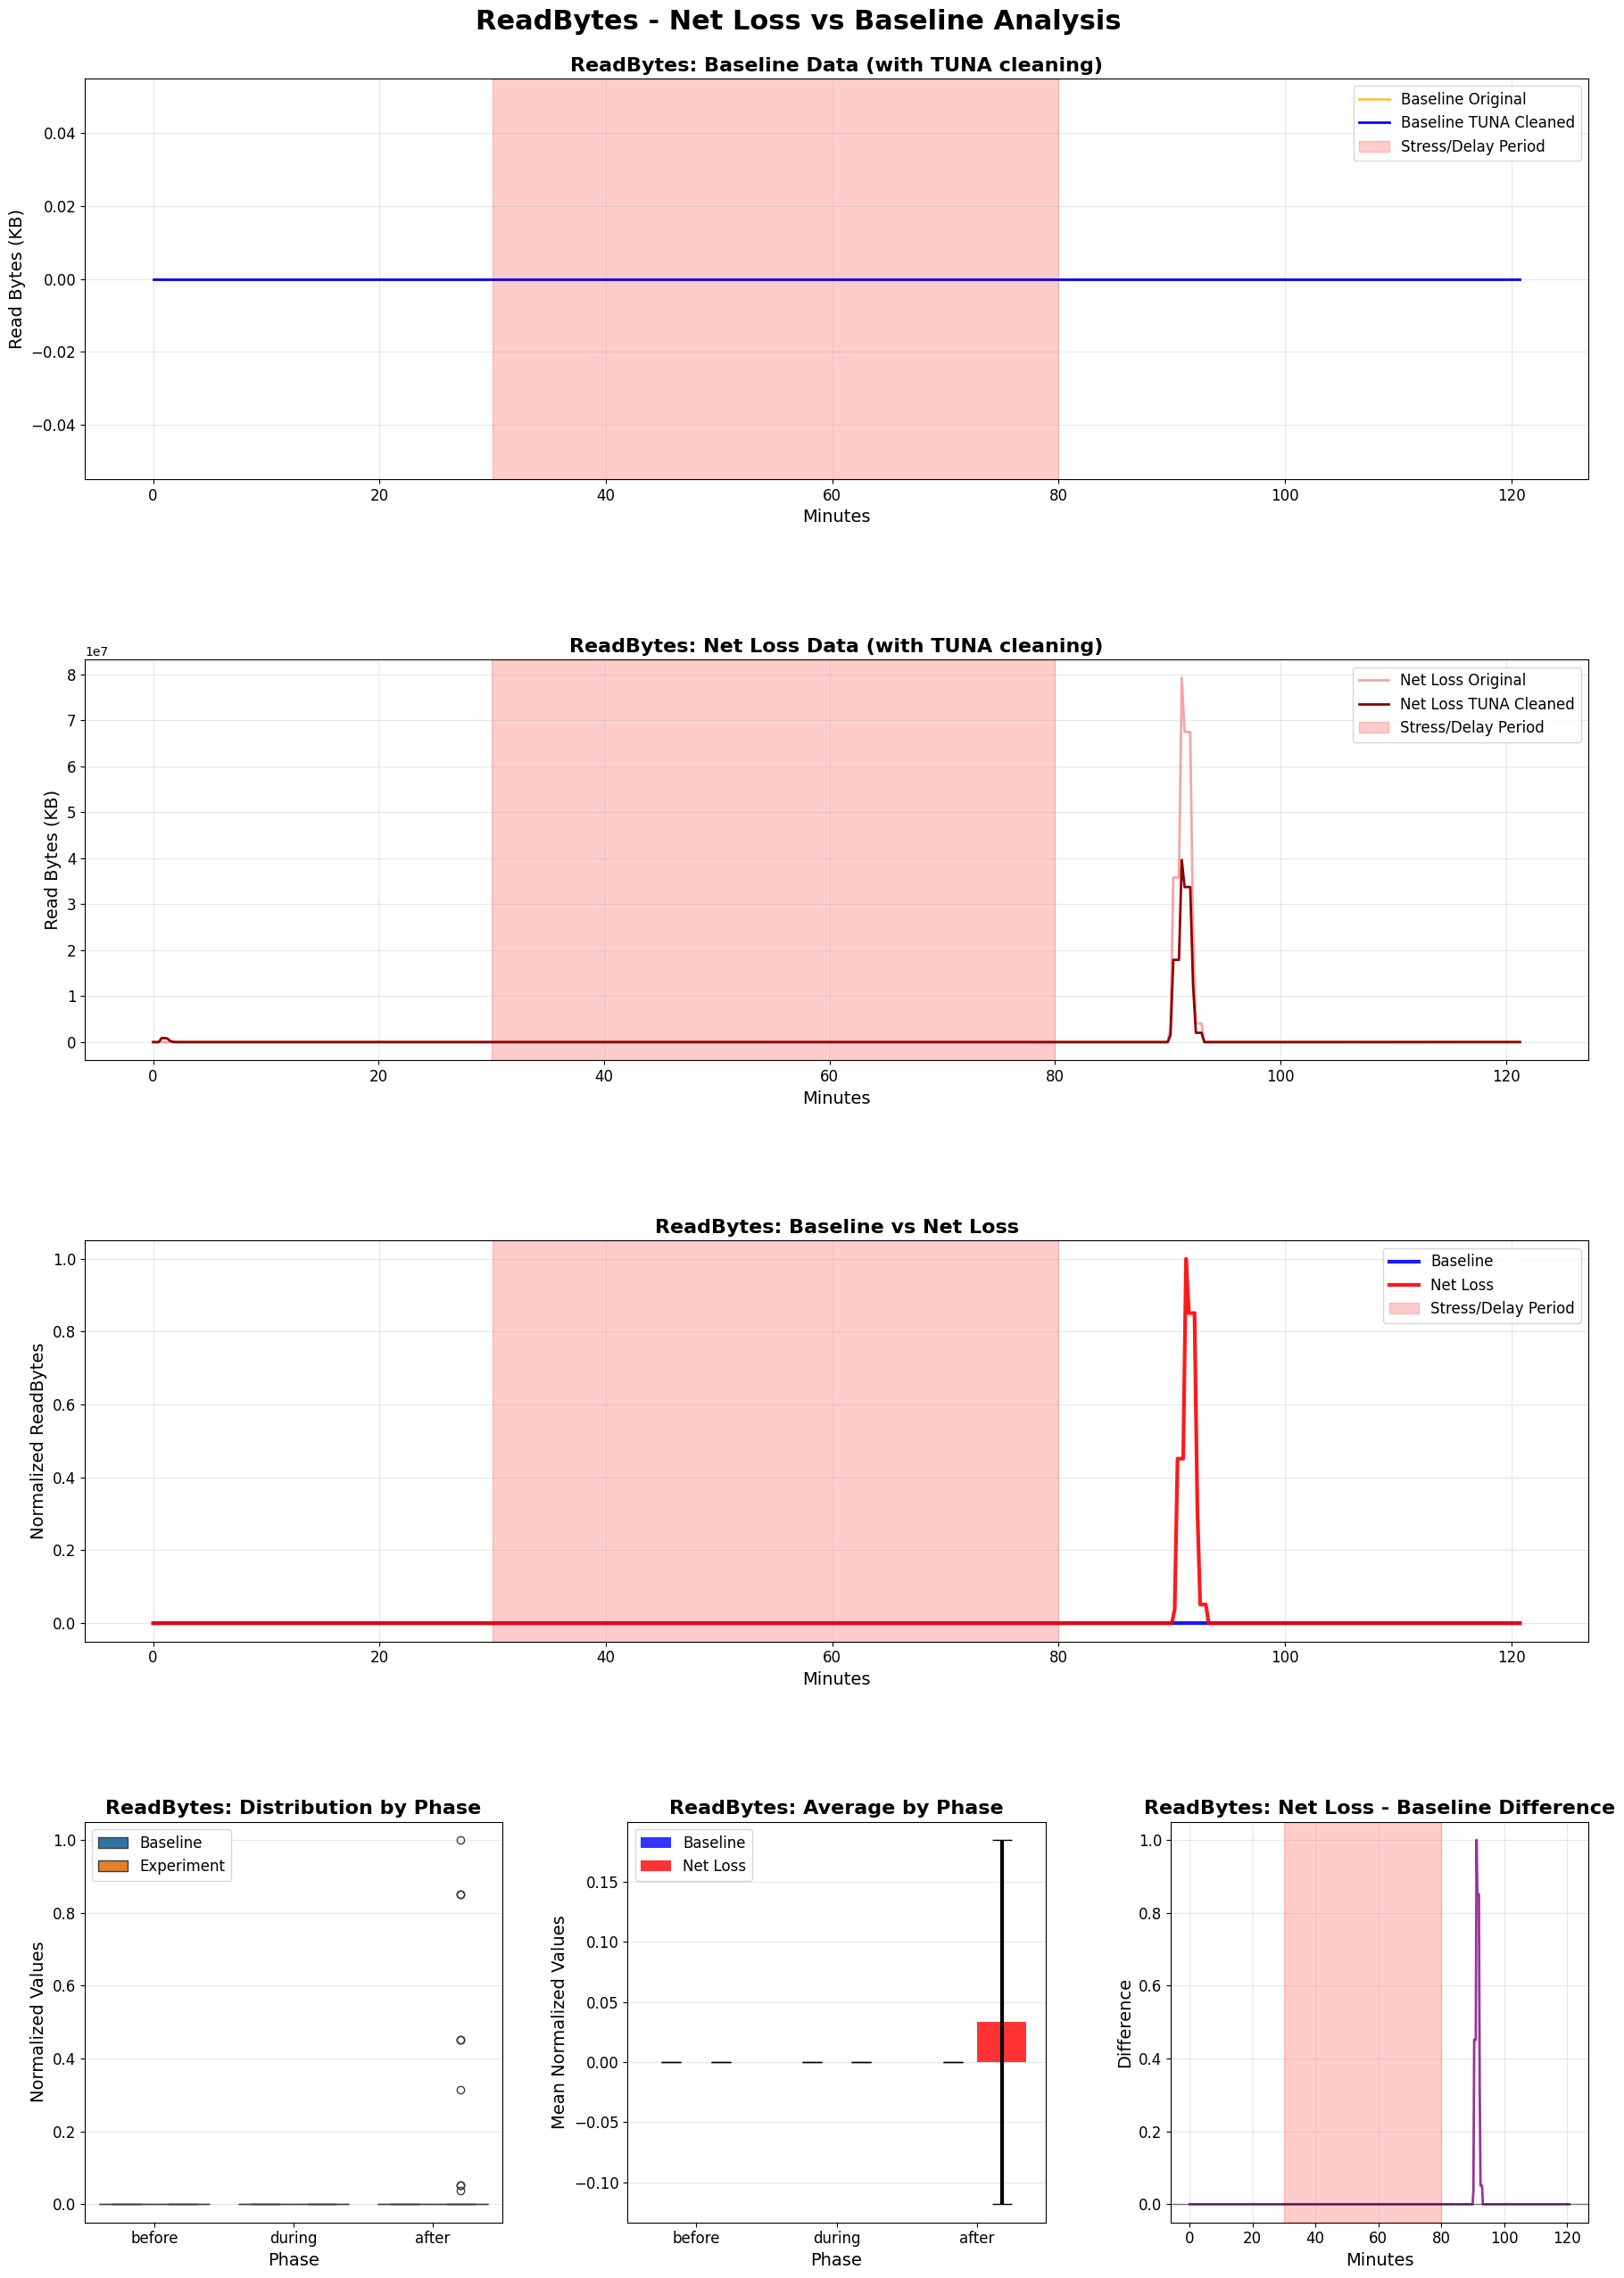


READBYTES - NET LOSS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  NET LOSS: 44 outliers removed
    Noise Reduction: 50.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0  0.0  0.0
before   0.0  0.0  0.0  0.0
during   0.0  0.0  0.0  0.0

NET LOSS STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.0332  0.1514  0.0  1.0
before  0.0000  0.0000  0.0  0.0
during  0.0000  0.0000  0.0  0.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=   nan, p=     nan (NOT SIGNIFICANT)
  DURING  : t=   nan, p=     nan (NOT SIGNIFICANT)
  AFTER   : t= -2.80, p=  0.0054 (SIGNIFICANT)

NET LOSS IMPACT:
  BEFORE  :   +0.00% (NO CHANGE)
  DURING  :   +0.00% (NO CHANGE)
  AFTER   :   +0.00% (NO CHANGE)

DISK I/O METRICS DETAILS:
  Metric: ReadBytes
  Metric type: Read Bytes (KB)
  Columns analyzed: ['openeuler-h

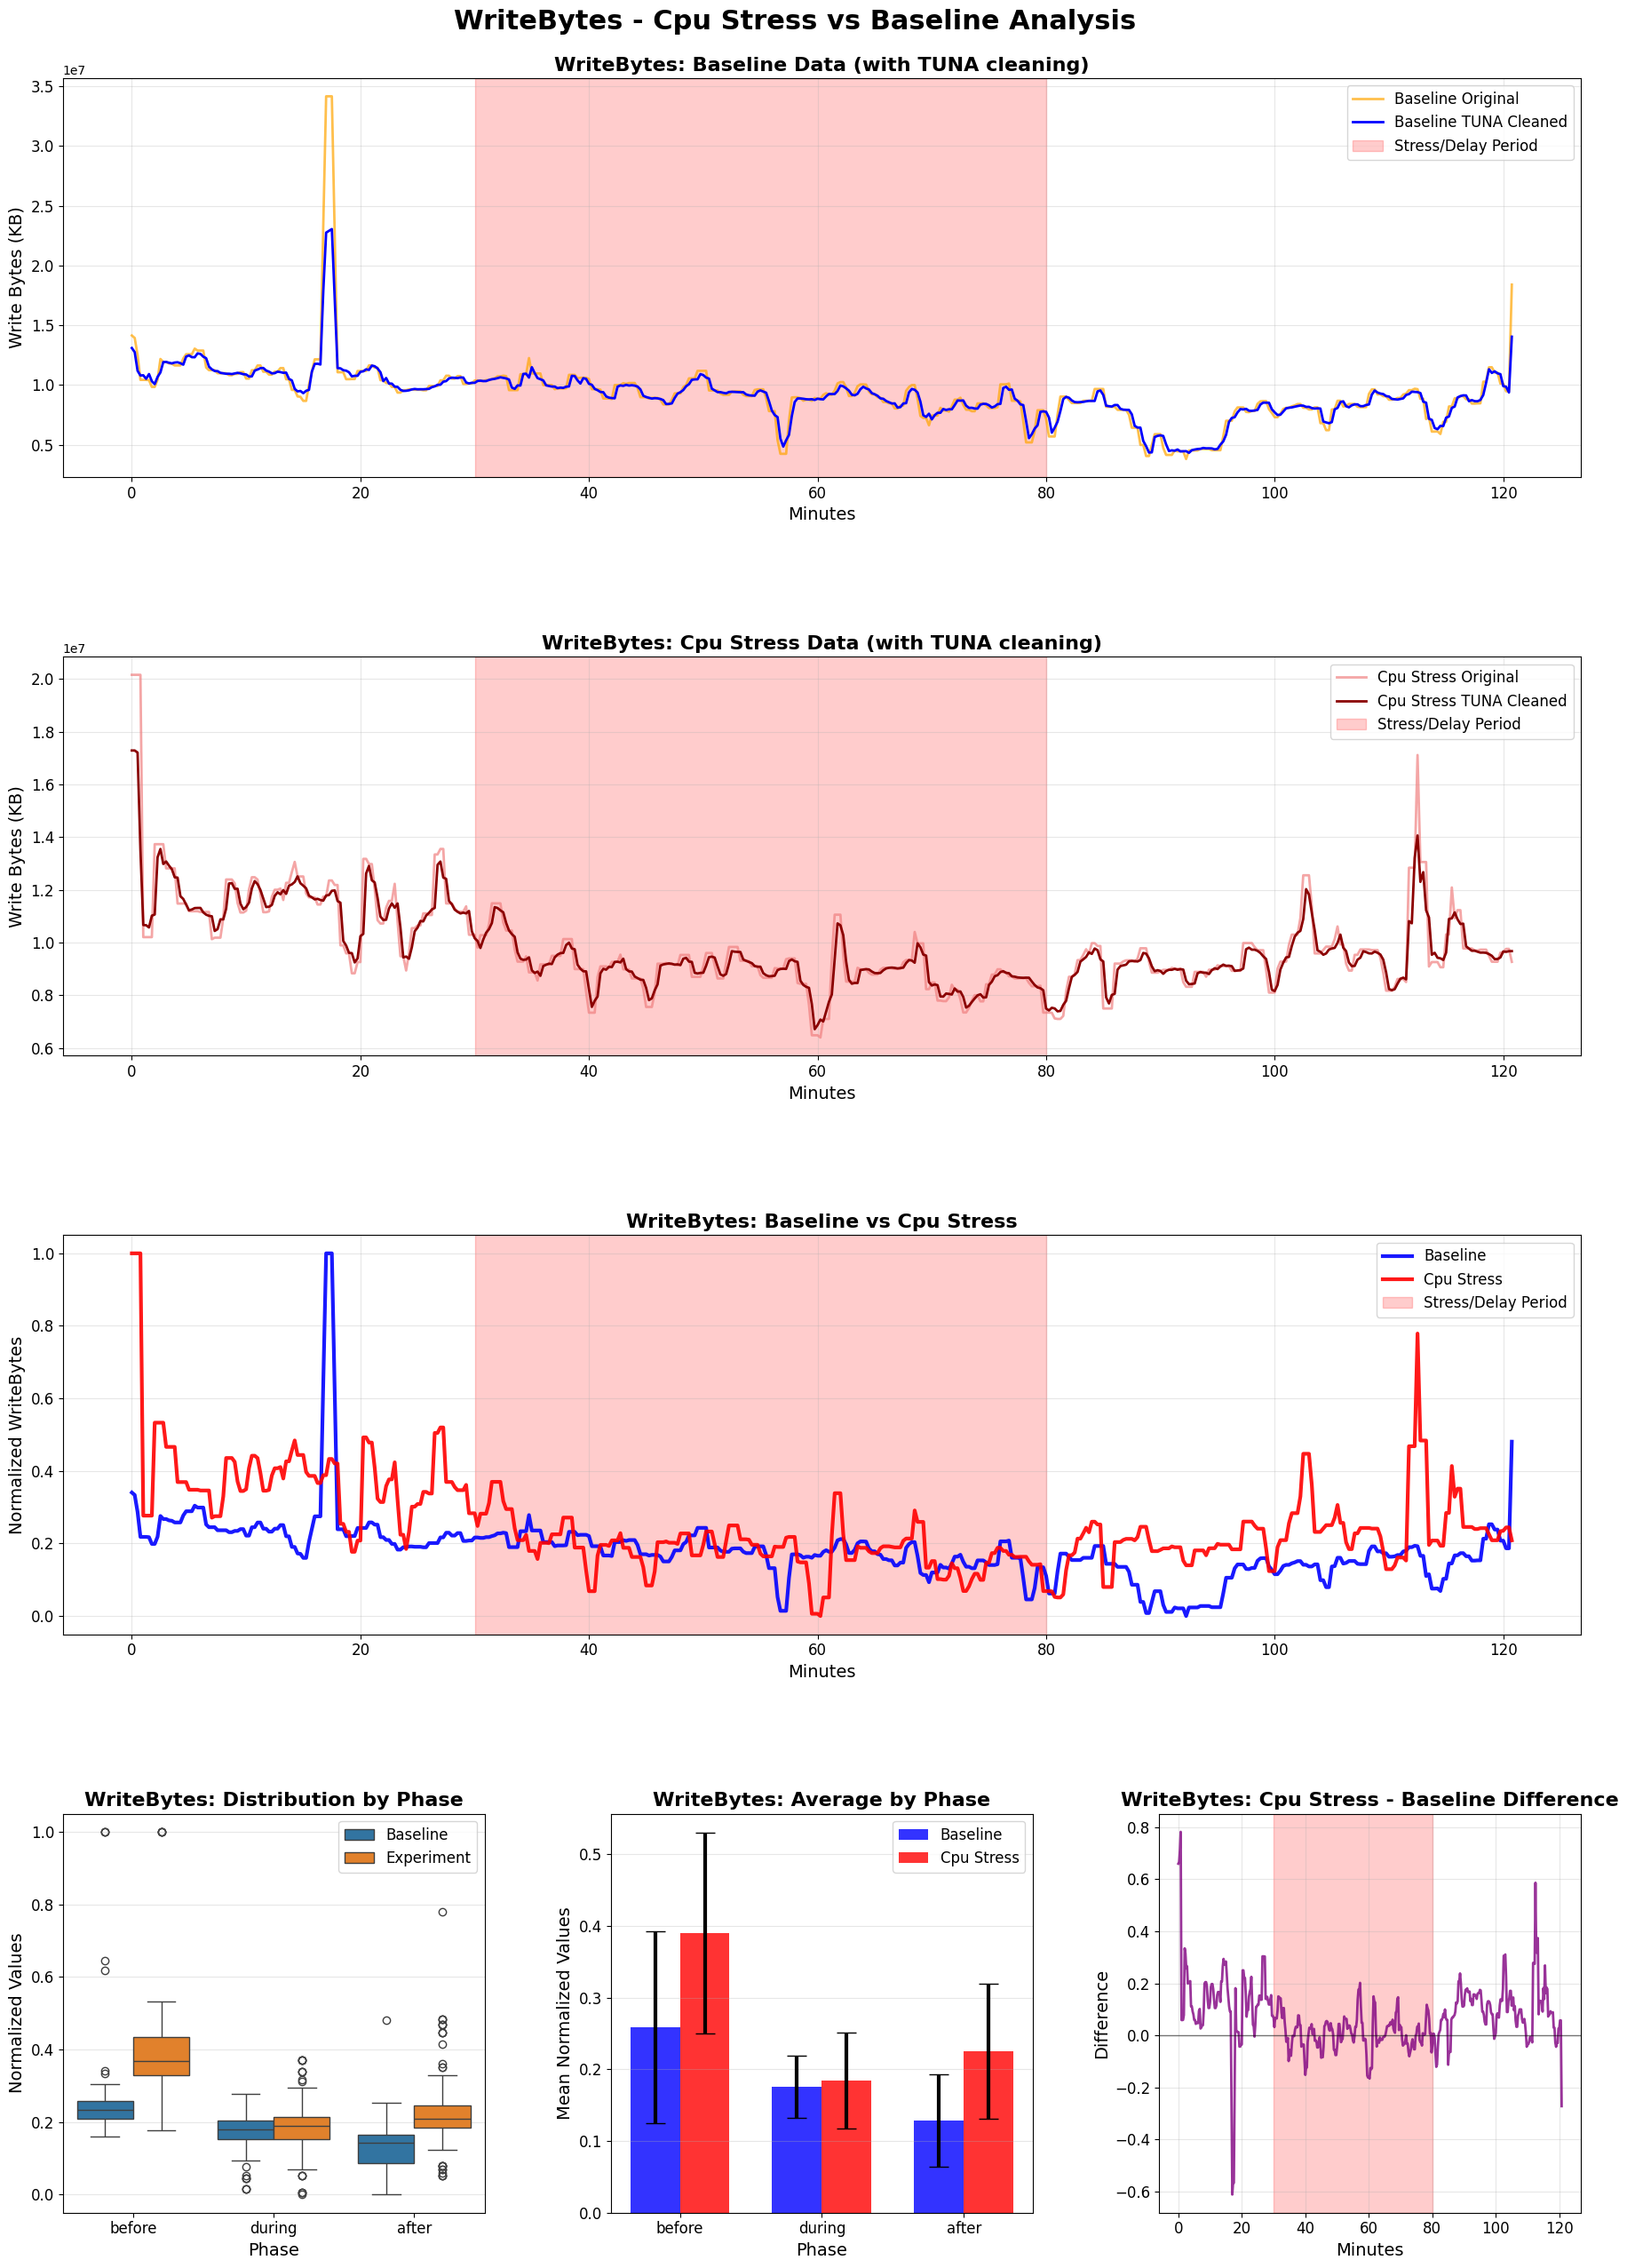


WRITEBYTES - CPU STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  CPU STRESS: 14 outliers removed
    Noise Reduction: 17.2%, Correlation: 0.944
  BASELINE: 46 outliers removed
    Noise Reduction: 26.1%, Correlation: 0.954

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1290  0.0643  0.0000  0.4808
before  0.2583  0.1341  0.1603  1.0000
during  0.1756  0.0435  0.0143  0.2784

CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.2254  0.0940  0.0512  0.7789
before  0.3901  0.1401  0.1771  1.0000
during  0.1842  0.0671  0.0000  0.3699

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -7.44, p=  0.0000 (SIGNIFICANT)
  DURING  : t= -1.52, p=  0.1283 (NOT SIGNIFICANT)
  AFTER   : t=-10.81, p=  0.0000 (SIGNIFICANT)

CPU STRESS IMPACT:
  BEFORE  :  +51.01% (INCREASE)
  DURING  :   +4.89% (INCREASE)
  AFTER   :  +74.77% (INCREASE)

DISK I/O METRICS DETA

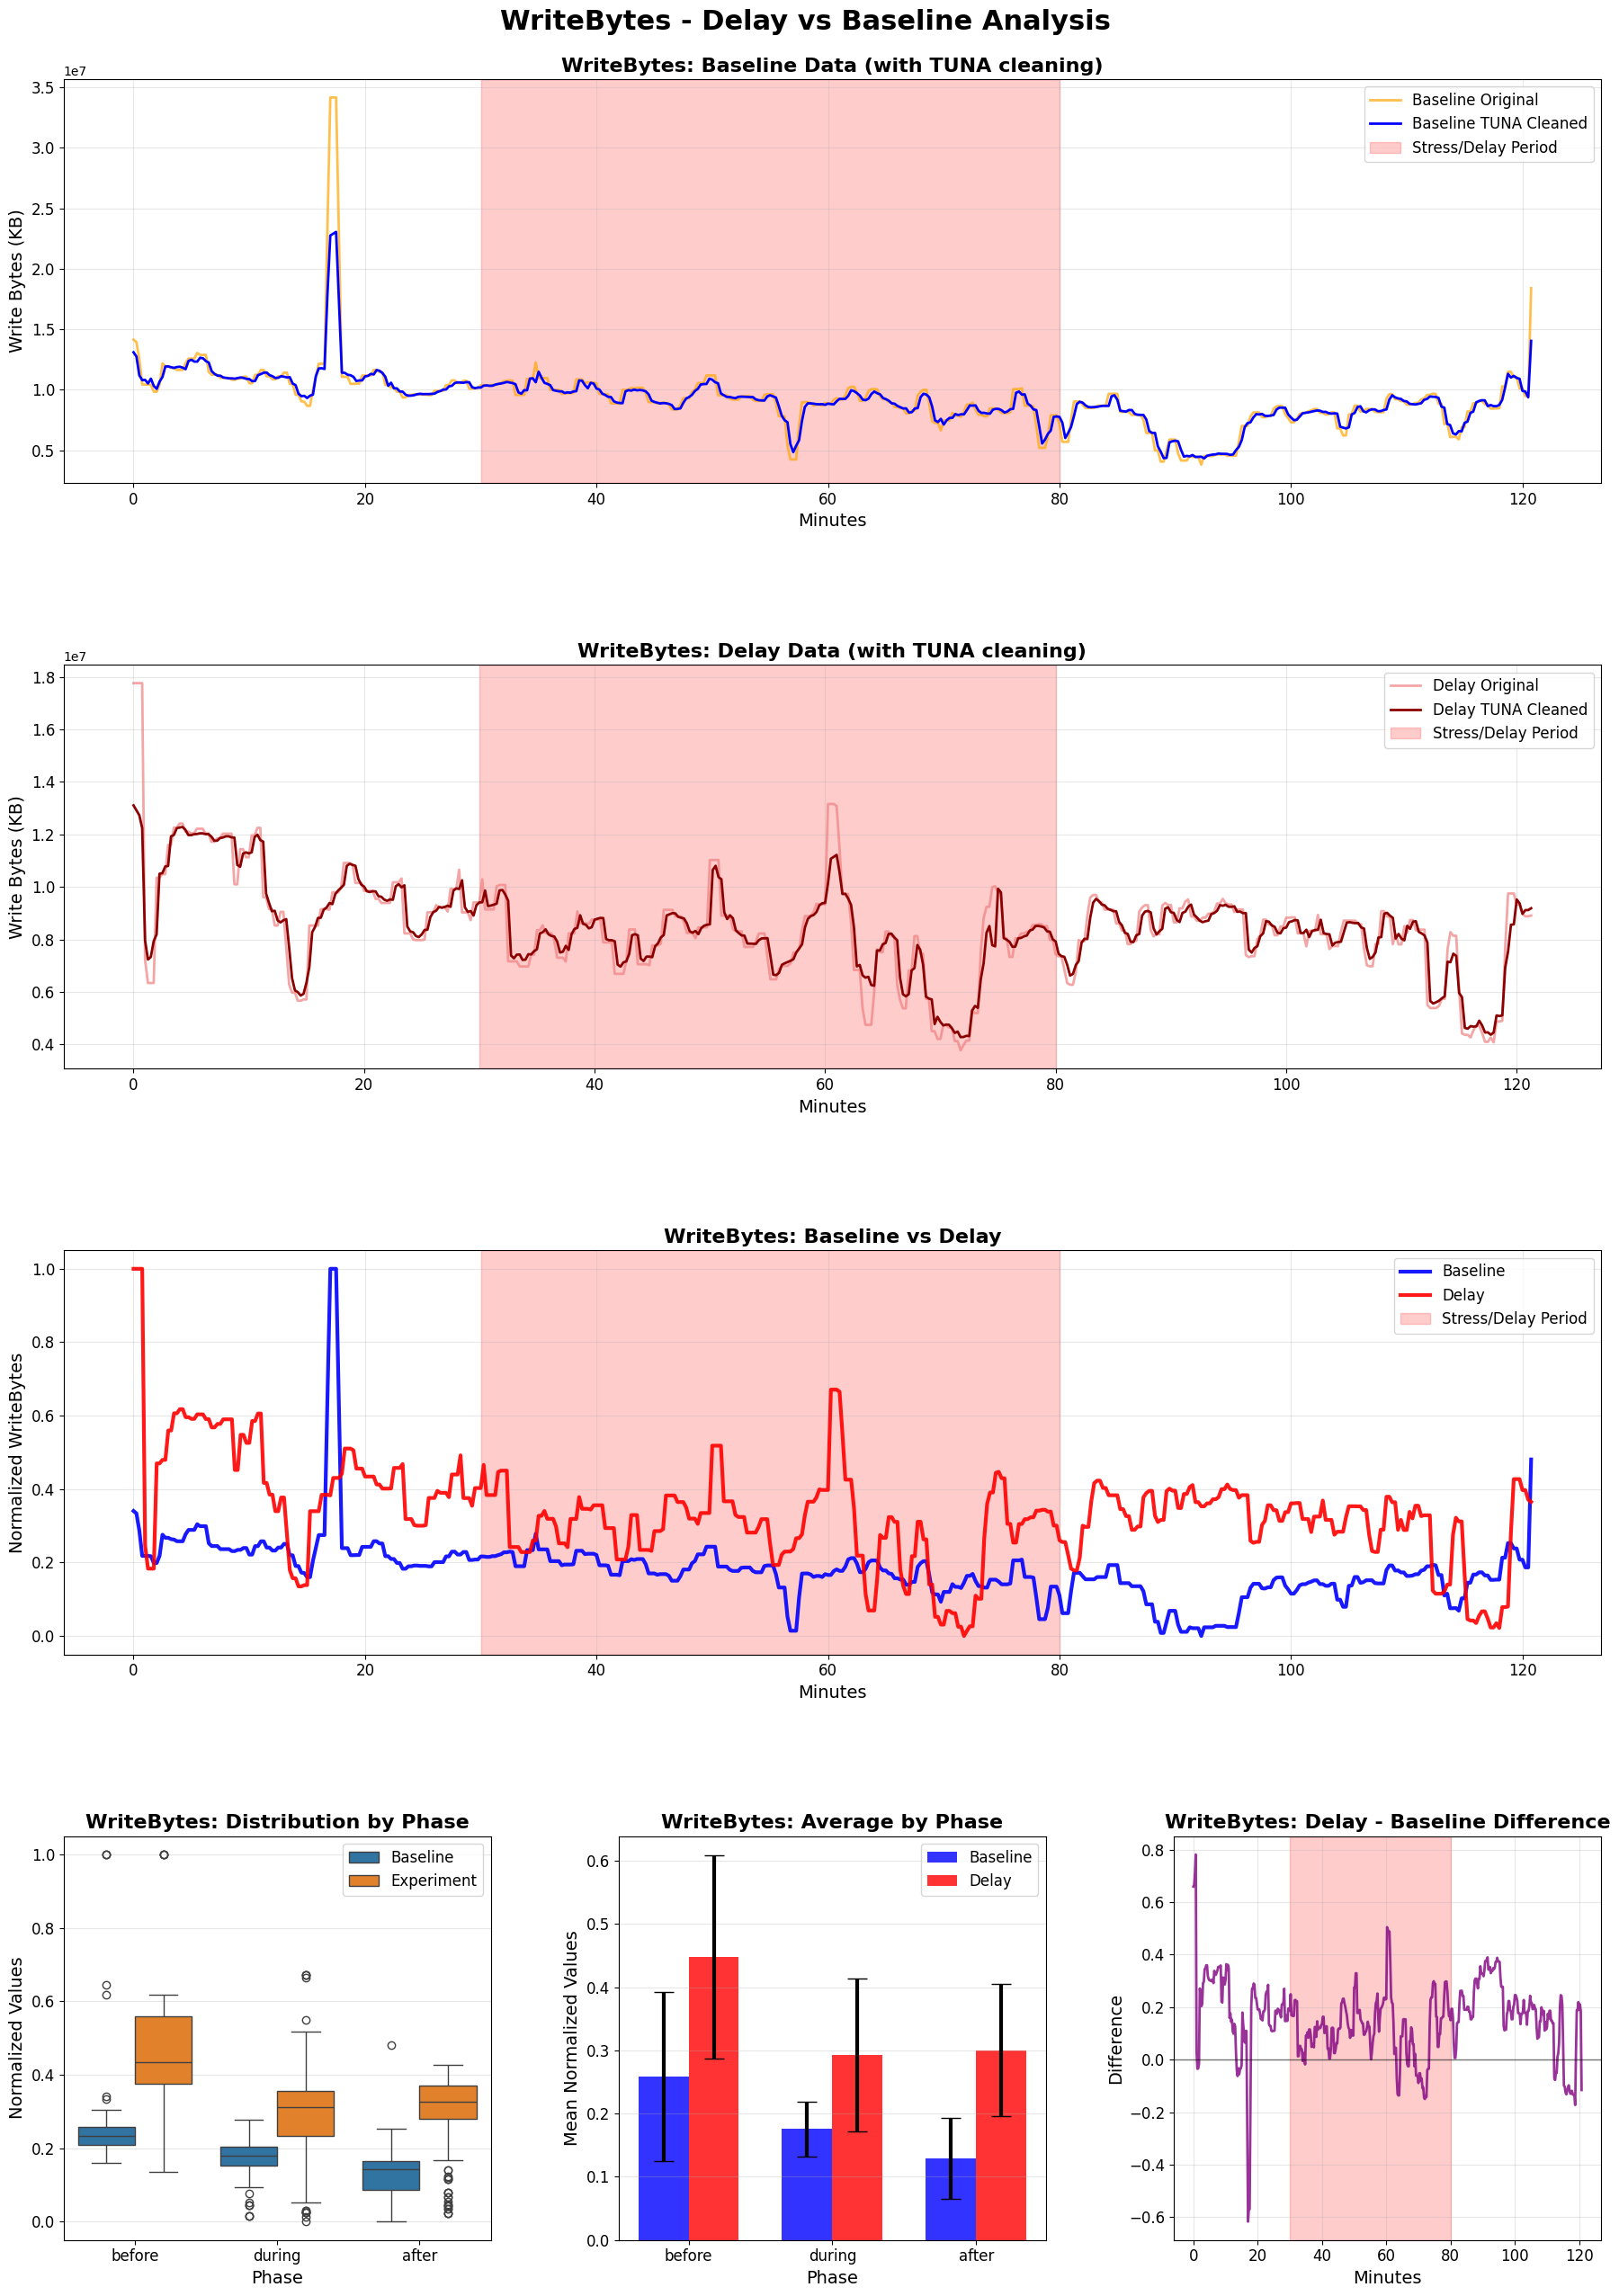


WRITEBYTES - DELAY VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  DELAY: 70 outliers removed
    Noise Reduction: 16.1%, Correlation: 0.933
  BASELINE: 46 outliers removed
    Noise Reduction: 26.1%, Correlation: 0.954

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1290  0.0643  0.0000  0.4808
before  0.2583  0.1341  0.1603  1.0000
during  0.1756  0.0435  0.0143  0.2784

DELAY STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.3006  0.1048  0.0217  0.4272
before  0.4479  0.1609  0.1351  1.0000
during  0.2933  0.1212  0.0000  0.6710

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -9.92, p=  0.0000 (SIGNIFICANT)
  DURING  : t=-12.95, p=  0.0000 (SIGNIFICANT)
  AFTER   : t=-17.83, p=  0.0000 (SIGNIFICANT)

DELAY IMPACT:
  BEFORE  :  +73.39% (INCREASE)
  DURING  :  +67.01% (INCREASE)
  AFTER   : +133.08% (INCREASE)

DISK I/O METRICS DETAILS:
  Metric: WriteByte

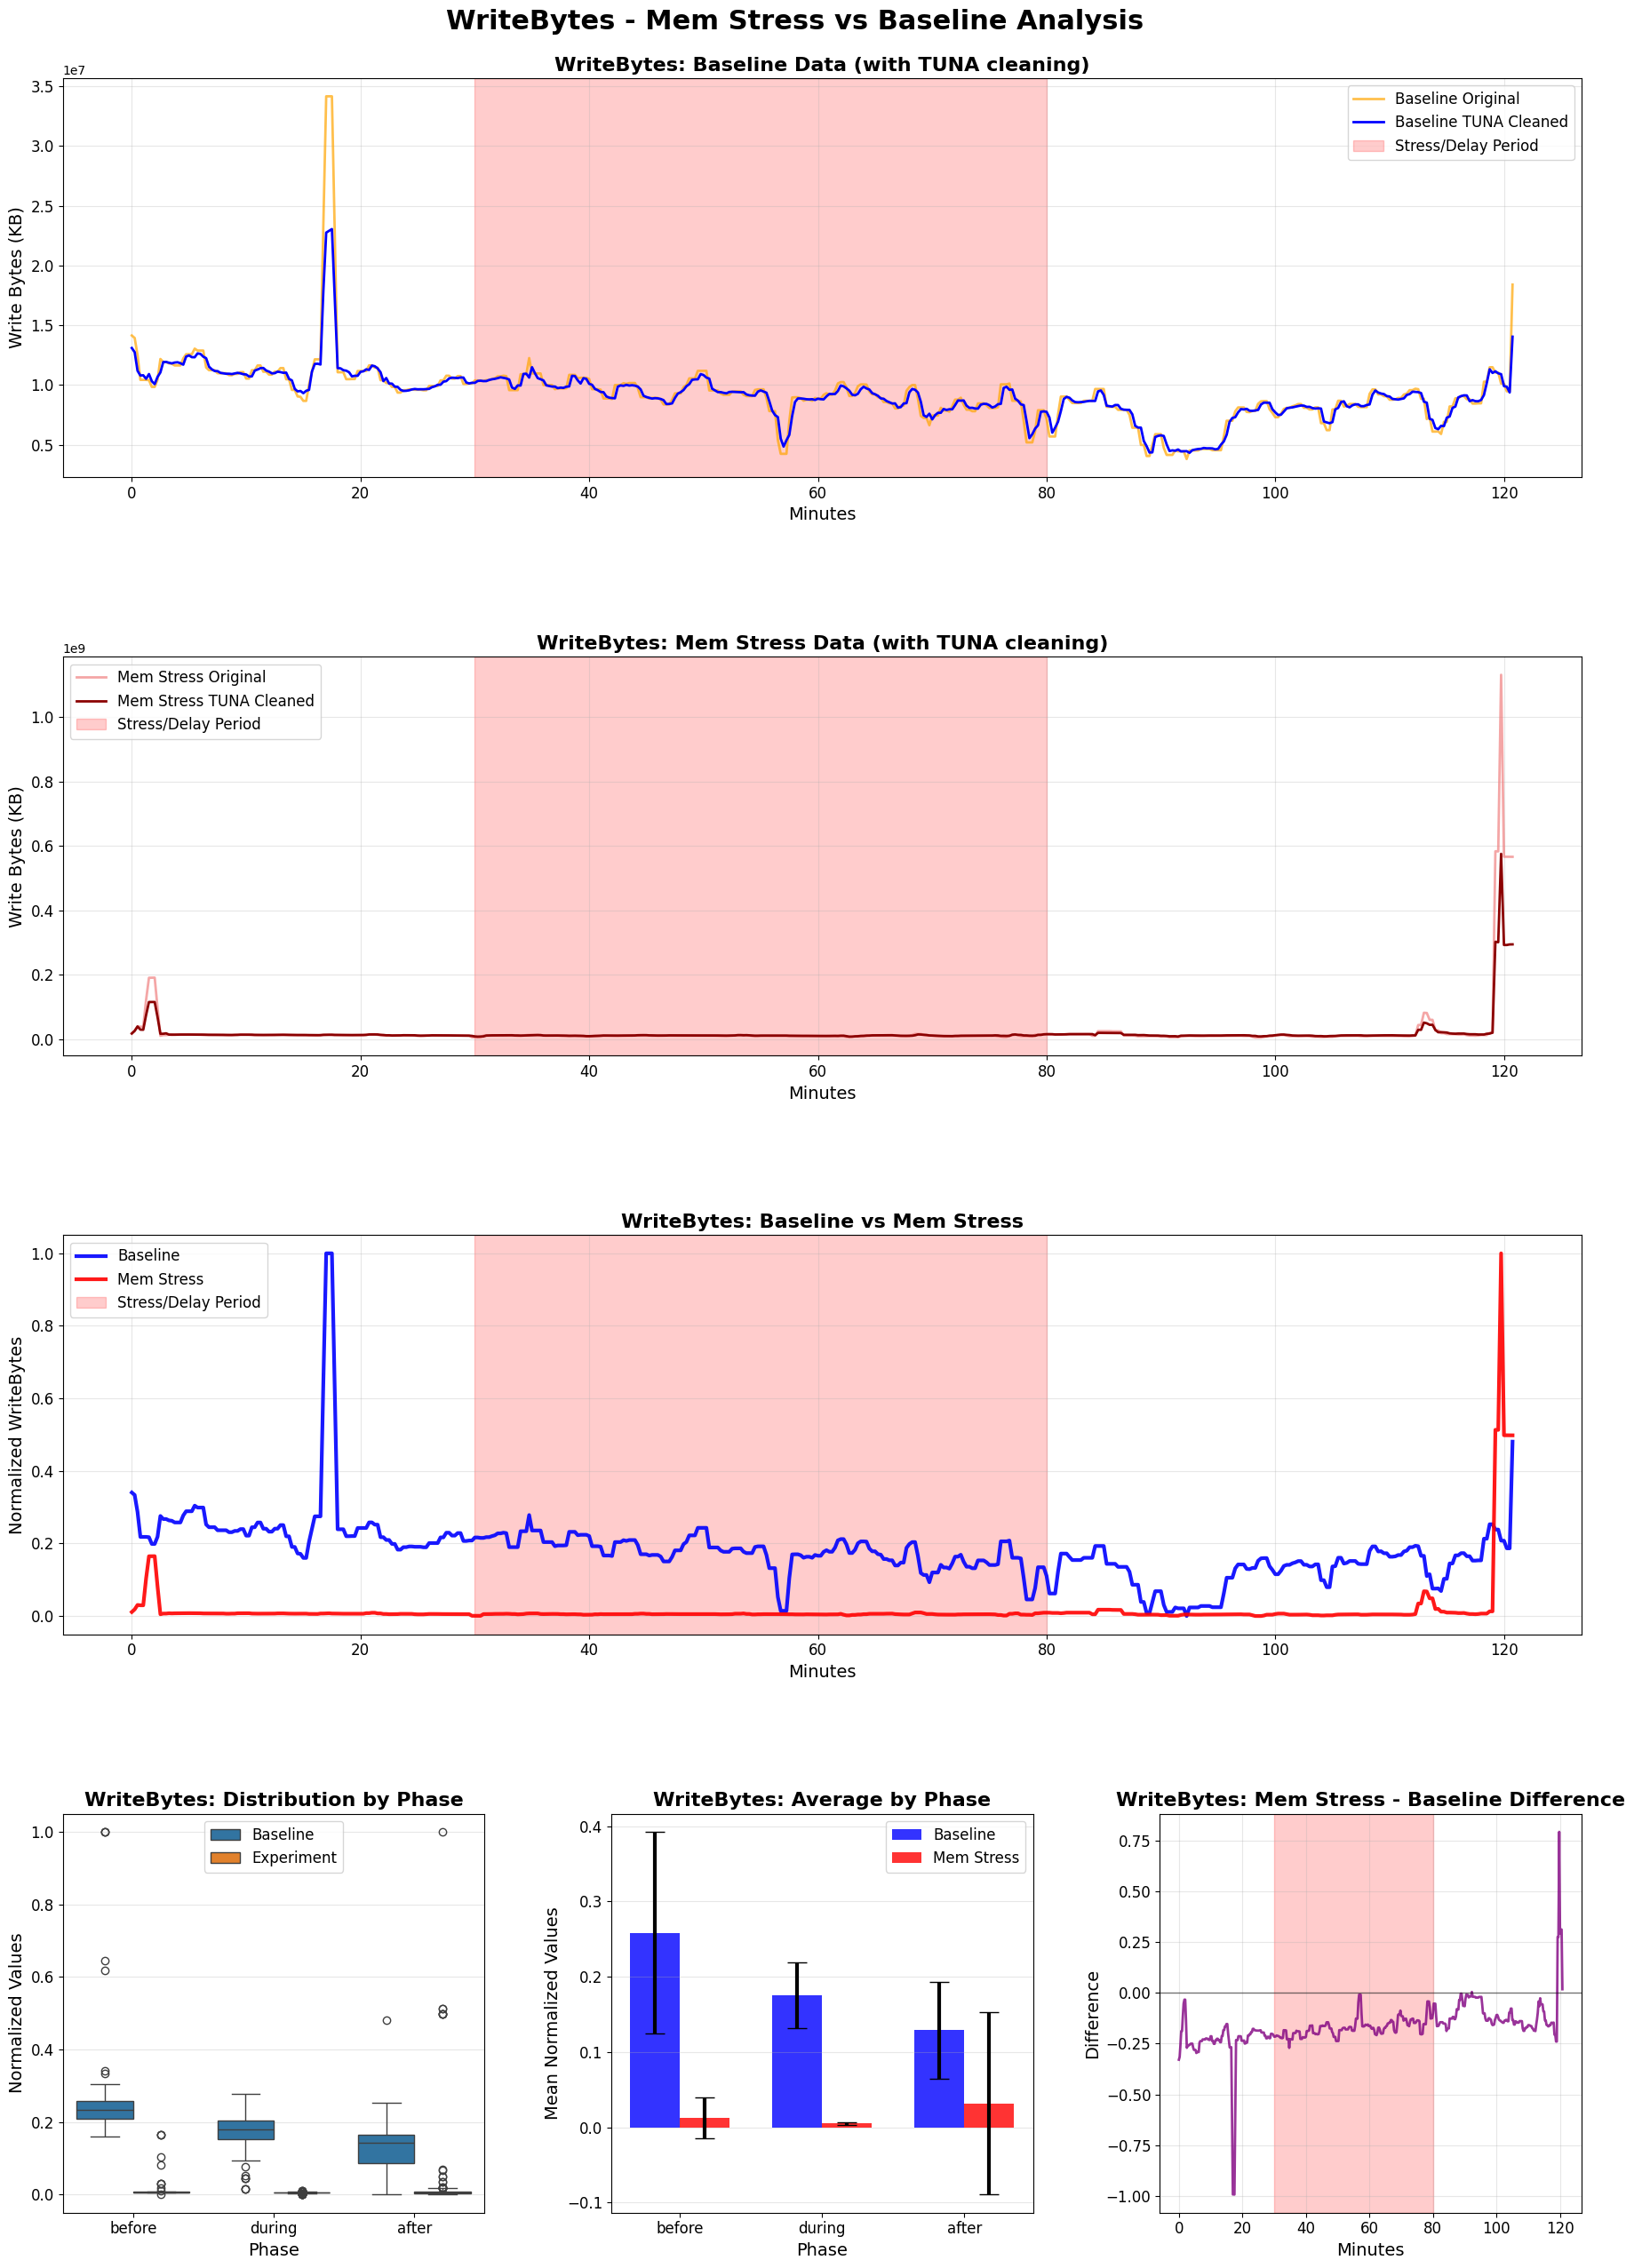


WRITEBYTES - MEM STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  MEM STRESS: 111 outliers removed
    Noise Reduction: 49.1%, Correlation: 0.999
  BASELINE: 46 outliers removed
    Noise Reduction: 26.1%, Correlation: 0.954

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1290  0.0643  0.0000  0.4808
before  0.2583  0.1341  0.1603  1.0000
during  0.1756  0.0435  0.0143  0.2784

MEM STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.0319  0.1212  0.0000  1.0000
before  0.0126  0.0272  0.0007  0.1650
during  0.0051  0.0014  0.0006  0.0098

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 19.68, p=  0.0000 (SIGNIFICANT)
  DURING  : t= 55.53, p=  0.0000 (SIGNIFICANT)
  AFTER   : t=  9.03, p=  0.0000 (SIGNIFICANT)

MEM STRESS IMPACT:
  BEFORE  :  -95.12% (DECREASE)
  DURING  :  -97.08% (DECREASE)
  AFTER   :  -75.23% (DECREASE)

DISK I/O METRICS DETAILS

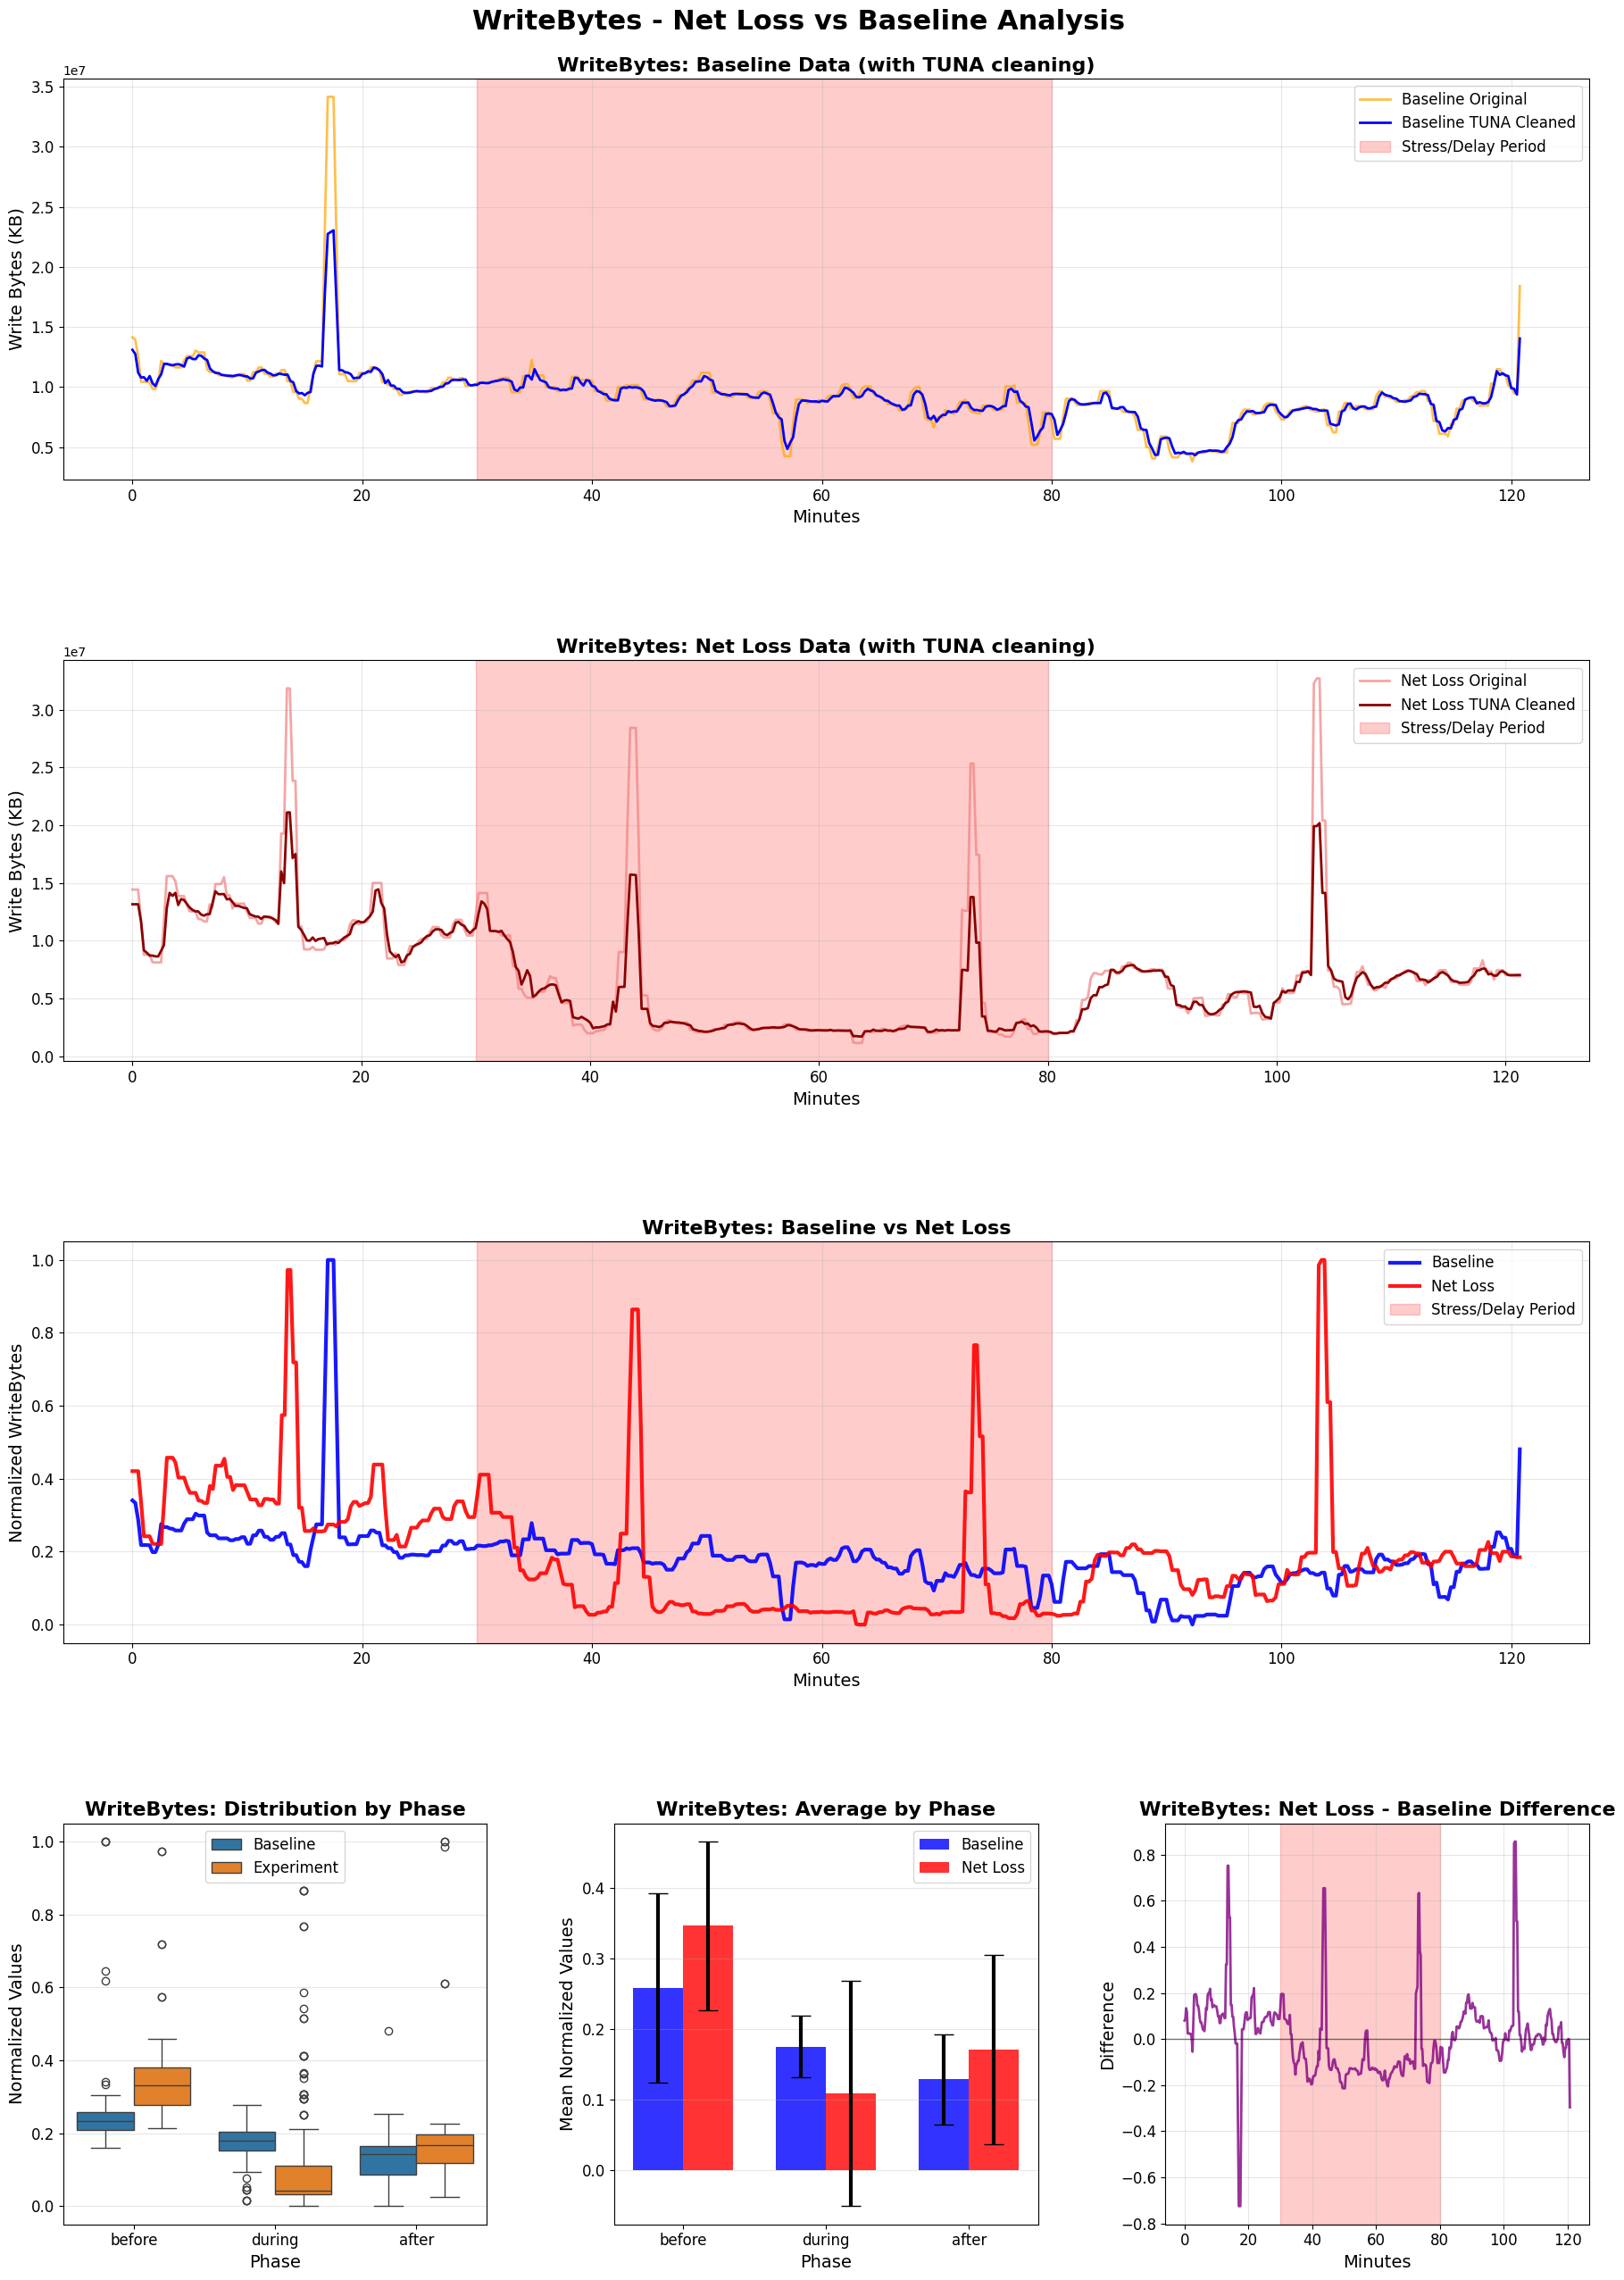


WRITEBYTES - NET LOSS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  NET LOSS: 319 outliers removed
    Noise Reduction: 23.8%, Correlation: 0.941
  BASELINE: 46 outliers removed
    Noise Reduction: 26.1%, Correlation: 0.954

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1290  0.0643  0.0000  0.4808
before  0.2583  0.1341  0.1603  1.0000
during  0.1756  0.0435  0.0143  0.2784

NET LOSS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1713  0.1343  0.0241  1.0000
before  0.3467  0.1196  0.2141  0.9726
during  0.1089  0.1597  0.0000  0.8643

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -5.39, p=  0.0000 (SIGNIFICANT)
  DURING  : t=  5.71, p=  0.0000 (SIGNIFICANT)
  AFTER   : t= -3.63, p=  0.0003 (SIGNIFICANT)

NET LOSS IMPACT:
  BEFORE  :  +34.21% (INCREASE)
  DURING  :  -37.97% (DECREASE)
  AFTER   :  +32.86% (INCREASE)

DISK I/O METRICS DETAILS:
  Metr

In [18]:
def calculate_disk_values(df, metric_name):
    exclude_cols = ['Time', 'Minutes', 'source']
    value_cols = [col for col in df.columns if col not in exclude_cols]
    
    if metric_name == 'BlockLatency':
        return df[value_cols[0]].values
    else:
        return df[value_cols].sum(axis=1).values

def normalize_series(series):
    min_val = series.min()
    max_val = series.max()
    if max_val > min_val:
        return (series - min_val) / (max_val - min_val)
    else:
        return pd.Series(np.zeros(len(series)), index=series.index)

def get_y_axis_label(metric_name):
    labels = {
        'BlockLatency': 'Block Latency (ms)',
        'ReadBytes': 'Read Bytes (KB)',
        'WriteBytes': 'Write Bytes (KB)',
        'DiskUtil': 'Disk Utilization (%)',
        'IOPS': 'I/O Operations per Second',
        'ThroughputRead': 'Read Throughput (MB/s)',
        'ThroughputWrite': 'Write Throughput (MB/s)'
    }
    return labels.get(metric_name, 'Disk I/O Value')

def analyze_and_plot_disk_comparison(metric_name, experiment_name, experiment_df, baseline_df, 
                                   tuna_results=None, delay_minutes=30, duration_minutes=50):
    
    experiment_values = calculate_disk_values(experiment_df, metric_name)
    baseline_values = calculate_disk_values(baseline_df, metric_name)
    
    experiment_series = pd.Series(experiment_values, index=experiment_df.index)
    baseline_series = pd.Series(baseline_values, index=baseline_df.index)
    
    experiment_cleaned = None
    baseline_cleaned = None
    if tuna_results and metric_name in tuna_results:
        if experiment_name in tuna_results[metric_name]:
            experiment_cleaned = pd.Series(tuna_results[metric_name][experiment_name]['cleaned'])
        if 'baseline' in tuna_results[metric_name]:
            baseline_cleaned = pd.Series(tuna_results[metric_name]['baseline']['cleaned'])
    
    experiment_norm = normalize_series(experiment_series)
    baseline_norm = normalize_series(baseline_series)
    
    min_length = min(len(experiment_norm), len(baseline_norm), len(experiment_df['Minutes']), len(baseline_df['Minutes']))
    
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm.iloc[:min_length],
        'Experiment': experiment_norm.iloc[:min_length],
        'Minutes': experiment_df['Minutes'].iloc[:min_length],
        'Baseline_Minutes': baseline_df['Minutes'].iloc[:min_length]
    })
    
    df_combined['difference'] = df_combined['Experiment'] - df_combined['Baseline']
    
    df_combined['phase'] = 'before'
    df_combined.loc[(df_combined['Minutes'] >= delay_minutes) & 
                   (df_combined['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'
    df_combined.loc[df_combined['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after'
    
    stats_baseline = df_combined.groupby('phase')['Baseline'].agg(['mean', 'std', 'min', 'max'])
    stats_experiment = df_combined.groupby('phase')['Experiment'].agg(['mean', 'std', 'min', 'max'])
    
    t_tests = {}
    available_phases = stats_baseline.index.tolist()
    
    for phase in ['before', 'during', 'after']:
        if phase in available_phases:
            data = df_combined[df_combined['phase'] == phase]
            if len(data) > 1:
                t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['Experiment'].dropna())
                t_tests[phase] = {'t': t_stat, 'p': p_value}
            else:
                t_tests[phase] = {'t': 0, 'p': 1}
        else:
            t_tests[phase] = {'t': 0, 'p': 1, 'note': 'Phase not present in data'}
    
    impact = {}
    for phase in ['before', 'during', 'after']:
        if phase in available_phases:
            baseline_mean = stats_baseline.loc[phase, 'mean']
            experiment_mean = stats_experiment.loc[phase, 'mean']
            if baseline_mean != 0:
                impact[phase] = ((experiment_mean - baseline_mean) / baseline_mean) * 100
            else:
                impact[phase] = 0
        else:
            impact[phase] = 0
    
    fig = plt.figure(figsize=(18, 26))
    
    y_label = get_y_axis_label(metric_name)
    
    plt.subplot(4, 1, 1)
    plt.plot(baseline_df['Minutes'], baseline_series, 
             label='Baseline Original', color='orange', alpha=0.7, linewidth=2)
    
    if baseline_cleaned is not None:
        plt.plot(baseline_df['Minutes'].iloc[:len(baseline_cleaned)], baseline_cleaned, 
                 label='Baseline TUNA Cleaned', linewidth=2, color='blue')
        title_suffix = " (with TUNA cleaning)"
    else:
        plt.plot(baseline_df['Minutes'], baseline_series, 
                 label='Baseline', linewidth=2, color='blue')
        title_suffix = ""
    
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress/Delay Period")
    plt.title(f'{metric_name}: Baseline Data{title_suffix}', fontsize=16, fontweight='bold')
    plt.xlabel('Minutes', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 1, 2)
    plt.plot(experiment_df['Minutes'], experiment_series, 
             label=f'{experiment_name.replace("_", " ").title()} Original', 
             alpha=0.7, color='lightcoral', linewidth=2)
    
    if experiment_cleaned is not None:
        plt.plot(experiment_df['Minutes'].iloc[:len(experiment_cleaned)], experiment_cleaned, 
                 label=f'{experiment_name.replace("_", " ").title()} TUNA Cleaned', 
                 linewidth=2, color='darkred')
        title_suffix = " (with TUNA cleaning)"
    else:
        plt.plot(experiment_df['Minutes'], experiment_series, 
                 label=f'{experiment_name.replace("_", " ").title()}', 
                 linewidth=2, color='darkred')
        title_suffix = ""
    
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress/Delay Period")
    plt.title(f'{metric_name}: {experiment_name.replace("_", " ").title()} Data{title_suffix}', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Minutes', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 1, 3)
    plt.plot(df_combined['Minutes'], df_combined['Baseline'], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(df_combined['Minutes'], df_combined['Experiment'], 
             label=f'{experiment_name.replace("_", " ").title()}', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress/Delay Period")
    plt.title(f"{metric_name}: Baseline vs {experiment_name.replace('_', ' ').title()}", 
              fontsize=16, fontweight='bold')
    plt.xlabel("Minutes", fontsize=14)
    plt.ylabel(f"Normalized {metric_name}", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 3, 10)
    box_data = pd.melt(df_combined[['Baseline', 'Experiment', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{metric_name}: Distribution by Phase', fontsize=16, fontweight='bold')
    plt.xlabel('Phase', fontsize=14)
    plt.ylabel('Normalized Values', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 3, 11)
    phases_to_plot = [p for p in ['before', 'during', 'after'] if p in available_phases]
    
    if len(phases_to_plot) > 0:
        x = np.arange(len(phases_to_plot))
        width = 0.35
        
        baseline_means = [stats_baseline.loc[p, 'mean'] for p in phases_to_plot]
        baseline_stds = [stats_baseline.loc[p, 'std'] for p in phases_to_plot]
        experiment_means = [stats_experiment.loc[p, 'mean'] for p in phases_to_plot]
        experiment_stds = [stats_experiment.loc[p, 'std'] for p in phases_to_plot]
        
        bars1 = plt.bar(x - width/2, baseline_means, width, 
                       label='Baseline', alpha=0.8, color='blue')
        bars2 = plt.bar(x + width/2, experiment_means, width, 
                       label=f'{experiment_name.replace("_", " ").title()}', alpha=0.8, color='red')
        
        plt.errorbar(x - width/2, baseline_means, yerr=baseline_stds, 
                    fmt='none', ecolor='black', capsize=8, linewidth=3)
        plt.errorbar(x + width/2, experiment_means, yerr=experiment_stds, 
                    fmt='none', ecolor='black', capsize=8, linewidth=3)
        
        plt.xticks(x, phases_to_plot)
    else:
        plt.text(0.5, 0.5, 'No phase data available', ha='center', va='center', 
                transform=plt.gca().transAxes, fontsize=14)
    
    plt.title(f'{metric_name}: Average by Phase', fontsize=16, fontweight='bold')
    plt.xlabel('Phase', fontsize=14)
    plt.ylabel('Mean Normalized Values', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplot(4, 3, 12)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{metric_name}: {experiment_name.replace("_", " ").title()} - Baseline Difference', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Minutes', fontsize=14)
    plt.ylabel('Difference', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.suptitle(f'{metric_name} - {experiment_name.replace("_", " ").title()} vs Baseline Analysis', 
                fontsize=22, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.45, wspace=0.3)
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"{metric_name.upper()} - {experiment_name.upper().replace('_', ' ')} VS BASELINE ANALYSIS")
    print(f"{'='*80}")
    
    if tuna_results and metric_name in tuna_results:
        print(f"\nTUNA CLEANING SUMMARY:")
        if experiment_name in tuna_results[metric_name]:
            exp_stats = tuna_results[metric_name][experiment_name]['stats']
            print(f"  {experiment_name.upper().replace('_', ' ')}: {exp_stats['outliers']} outliers removed")
            print(f"    Noise Reduction: {exp_stats['noise_reduction']:.1f}%, Correlation: {exp_stats['correlation']:.3f}")
        
        if 'baseline' in tuna_results[metric_name]:
            base_stats = tuna_results[metric_name]['baseline']['stats']
            print(f"  BASELINE: {base_stats['outliers']} outliers removed")
            print(f"    Noise Reduction: {base_stats['noise_reduction']:.1f}%, Correlation: {base_stats['correlation']:.3f}")

    print(f"\nBASELINE STATISTICS BY PHASE:")
    if len(stats_baseline) > 0:
        print(stats_baseline.round(4))
    else:
        print("  No phase data available")

    print(f"\n{experiment_name.upper().replace('_', ' ')} STATISTICS BY PHASE:")
    if len(stats_experiment) > 0:
        print(stats_experiment.round(4))
    else:
        print("  No phase data available")

    print(f"\nSTATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        if 'note' in test:
            print(f"  {phase.upper():8}: {test['note']}")
        else:
            sig = "SIGNIFICANT" if test['p'] < 0.05 else "NOT SIGNIFICANT"
            print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")

    print(f"\n{experiment_name.upper().replace('_', ' ')} IMPACT:")
    for phase, change in impact.items():
        if change == 0 and phase not in available_phases:
            print(f"  {phase.upper():8}: Phase not present in data")
        else:
            direction = "INCREASE" if change > 0 else "DECREASE" if change < 0 else "NO CHANGE"
            print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")

    value_cols = [col for col in experiment_df.columns if col not in ['Time', 'Minutes', 'source']]
    print(f"\nDISK I/O METRICS DETAILS:")
    print(f"  Metric: {metric_name}")
    print(f"  Metric type: {y_label}")
    print(f"  Columns analyzed: {value_cols}")
    print(f"  Data points analyzed: {len(df_combined)}")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_experiment': stats_experiment,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'tuna_info': {
            'experiment_cleaned': experiment_cleaned is not None,
            'baseline_cleaned': baseline_cleaned is not None
        }
    }

def run_comprehensive_disk_analysis(all_datasets, tuna_results=None):
    analysis_results = {}
    
    for metric_name, experiments in all_datasets.items():
        print(f"\n🔍 Analyzing {metric_name}...")
        analysis_results[metric_name] = {}
        
        baseline_df = experiments['baseline']
        
        for experiment_name, experiment_df in experiments.items():
            if experiment_name != 'baseline':
                print(f"\n📊 Comparing {metric_name}: {experiment_name} stress vs baseline")
                
                result = analyze_and_plot_disk_comparison(
                    metric_name=metric_name,
                    experiment_name=experiment_name,
                    experiment_df=experiment_df,
                    baseline_df=baseline_df,
                    tuna_results=tuna_results
                )
                
                analysis_results[metric_name][experiment_name] = result
    
    return analysis_results

disk_results = run_comprehensive_disk_analysis(all_datasets, tuna_results)